/tmp/ipykernel_6494/3182571195.py:229: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 4, figsize=(15, 6))


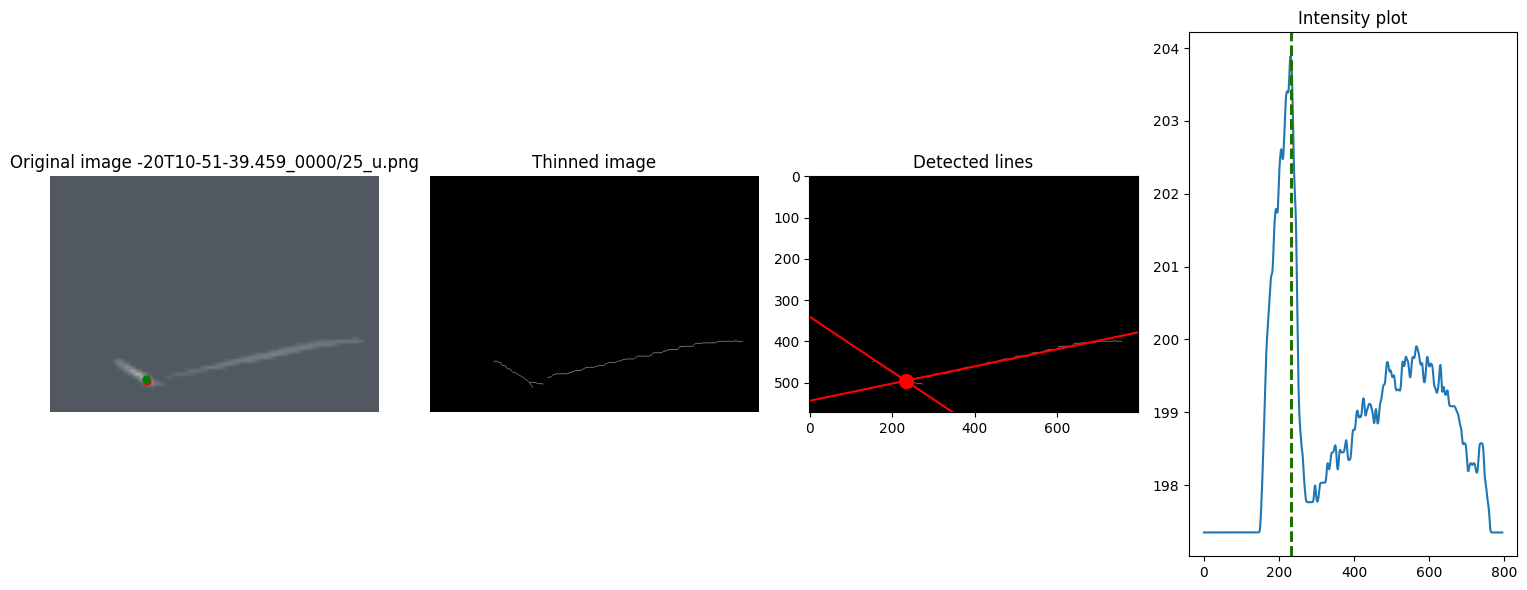

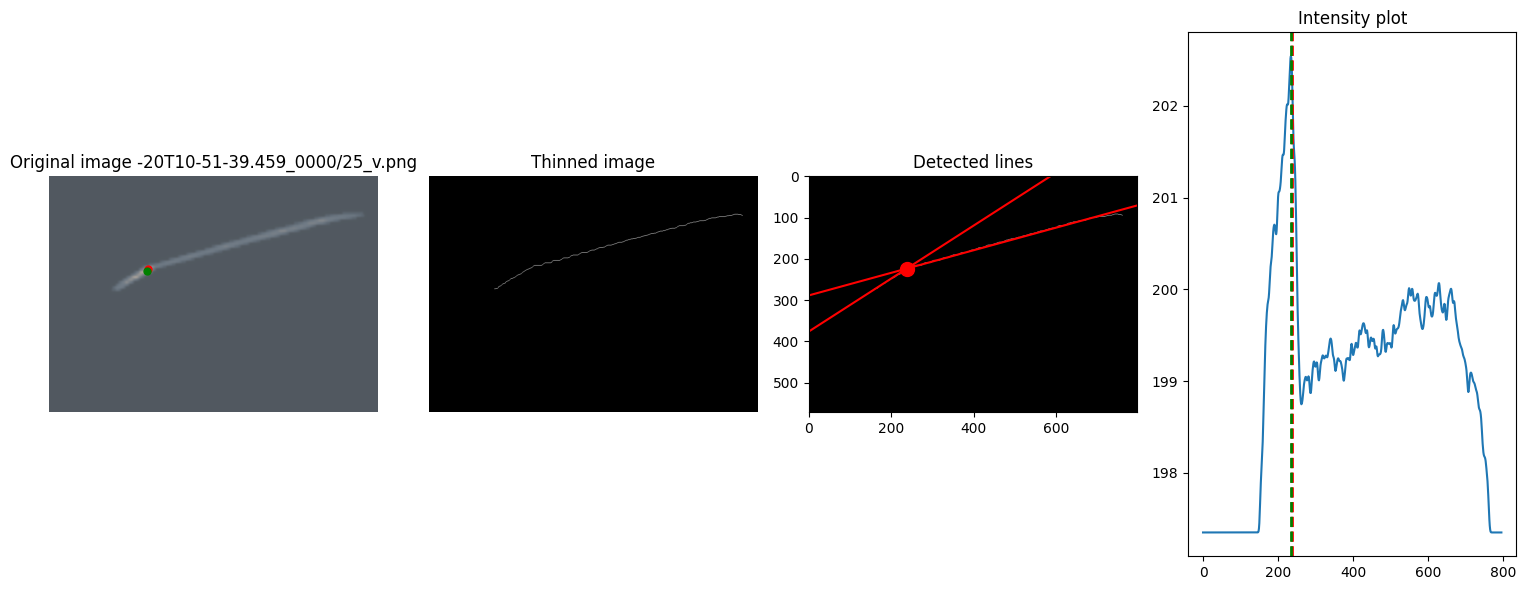

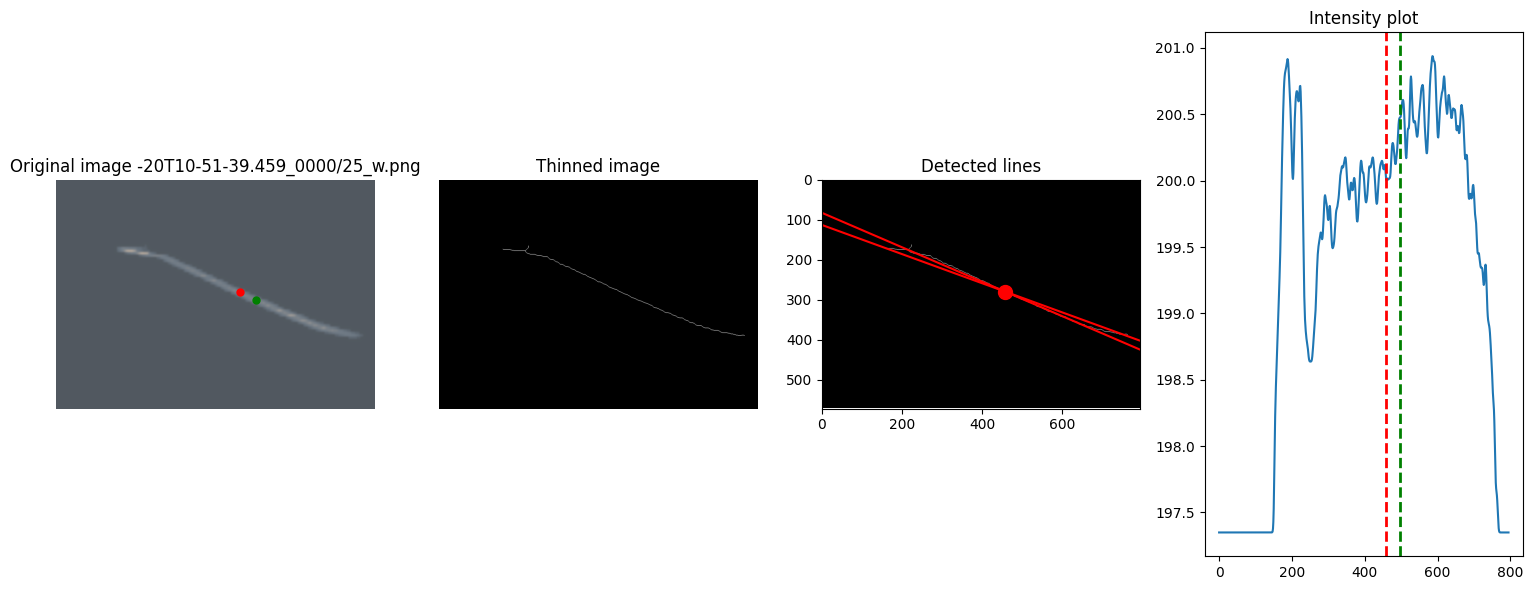

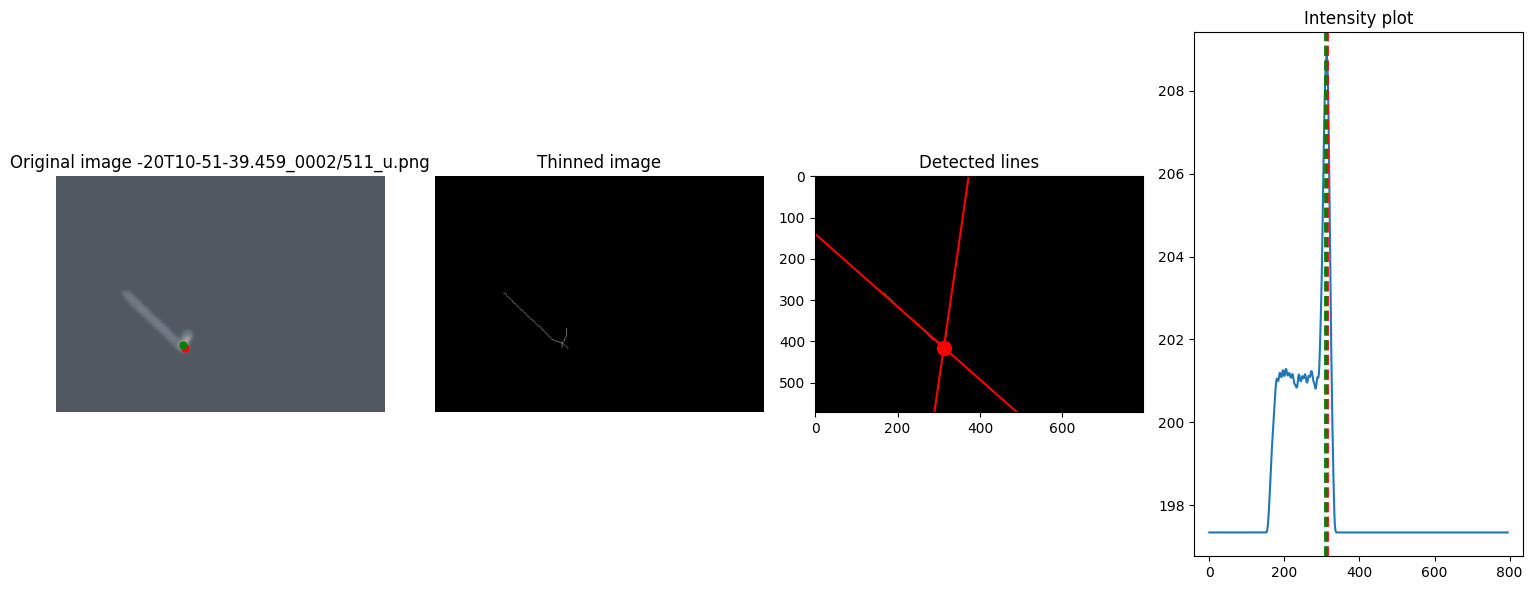

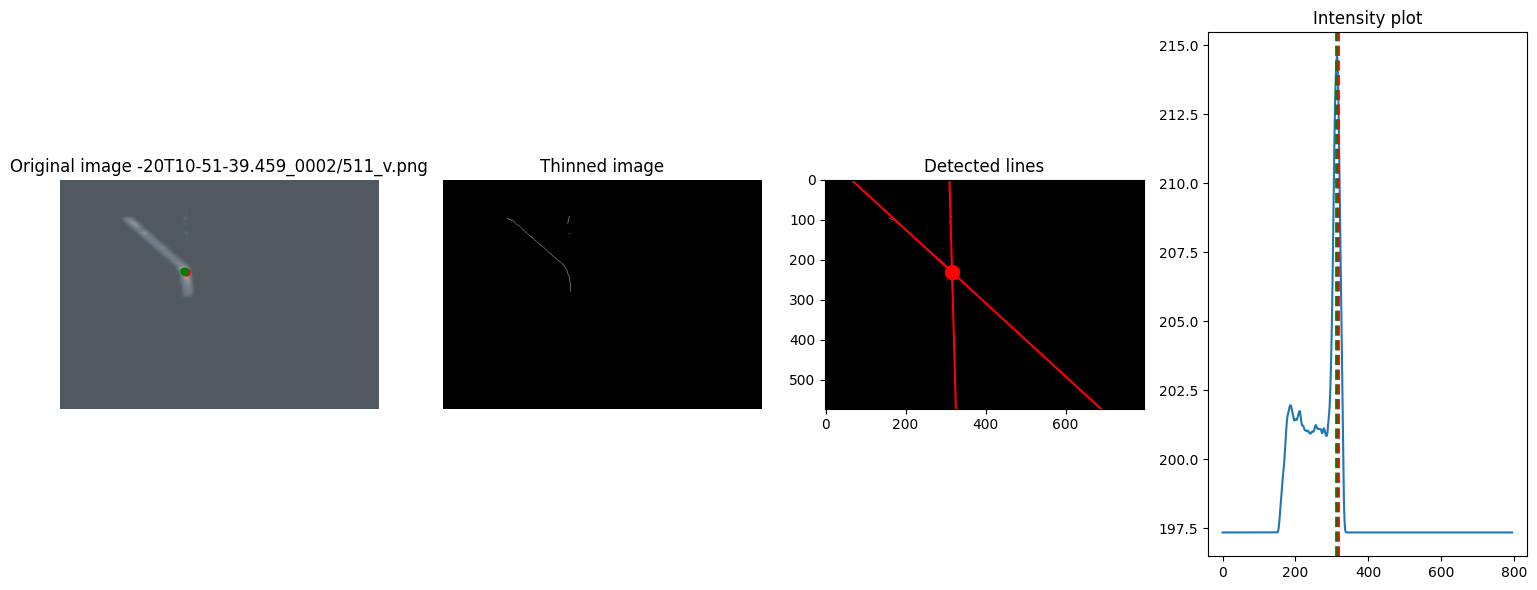

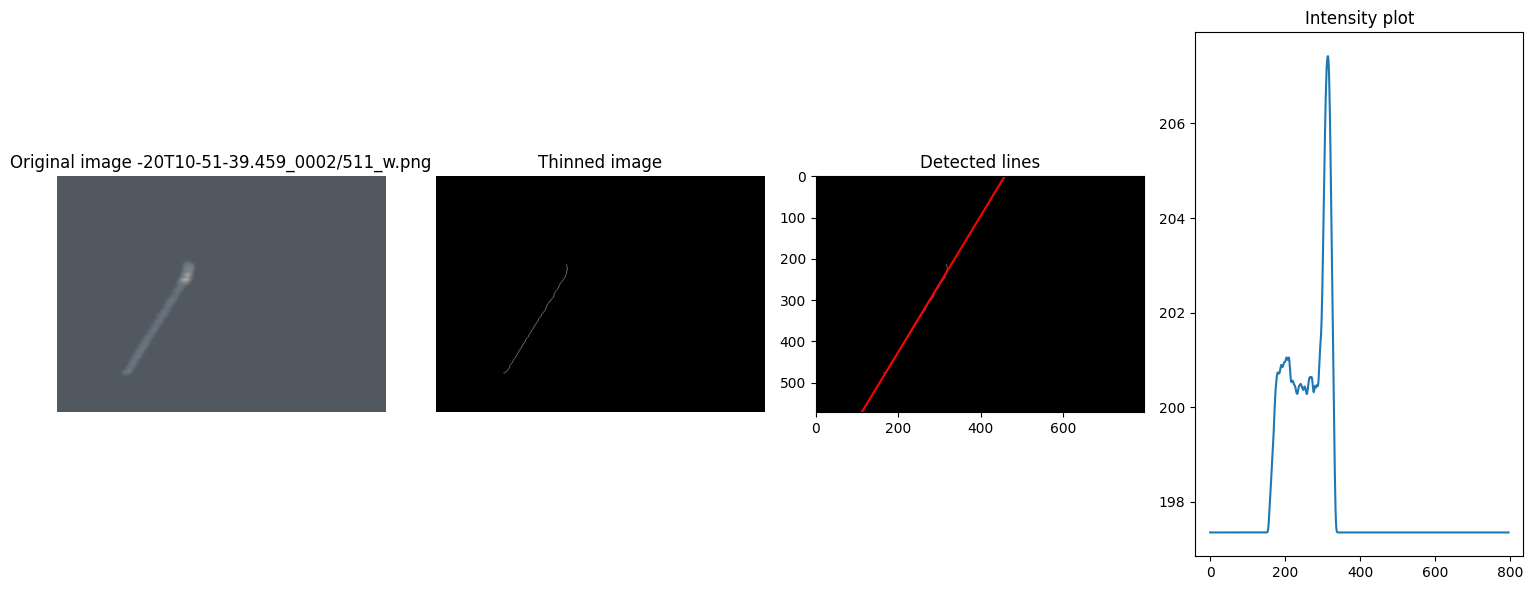

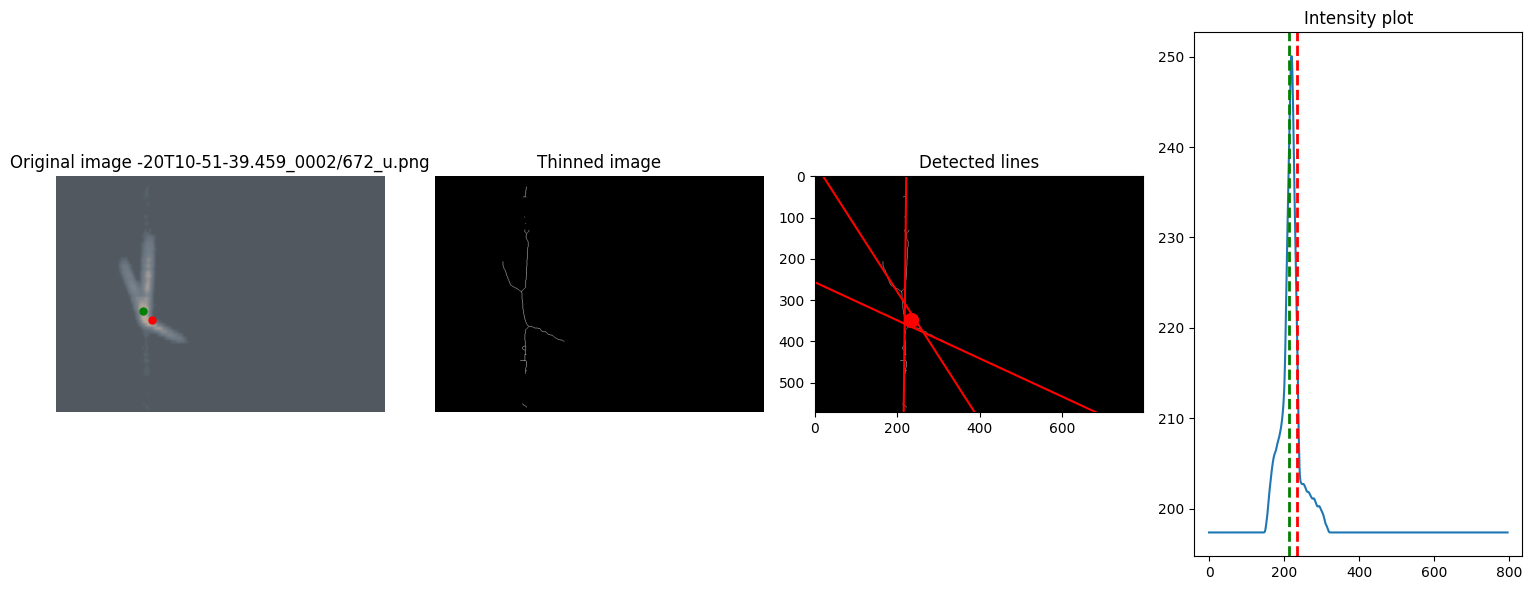

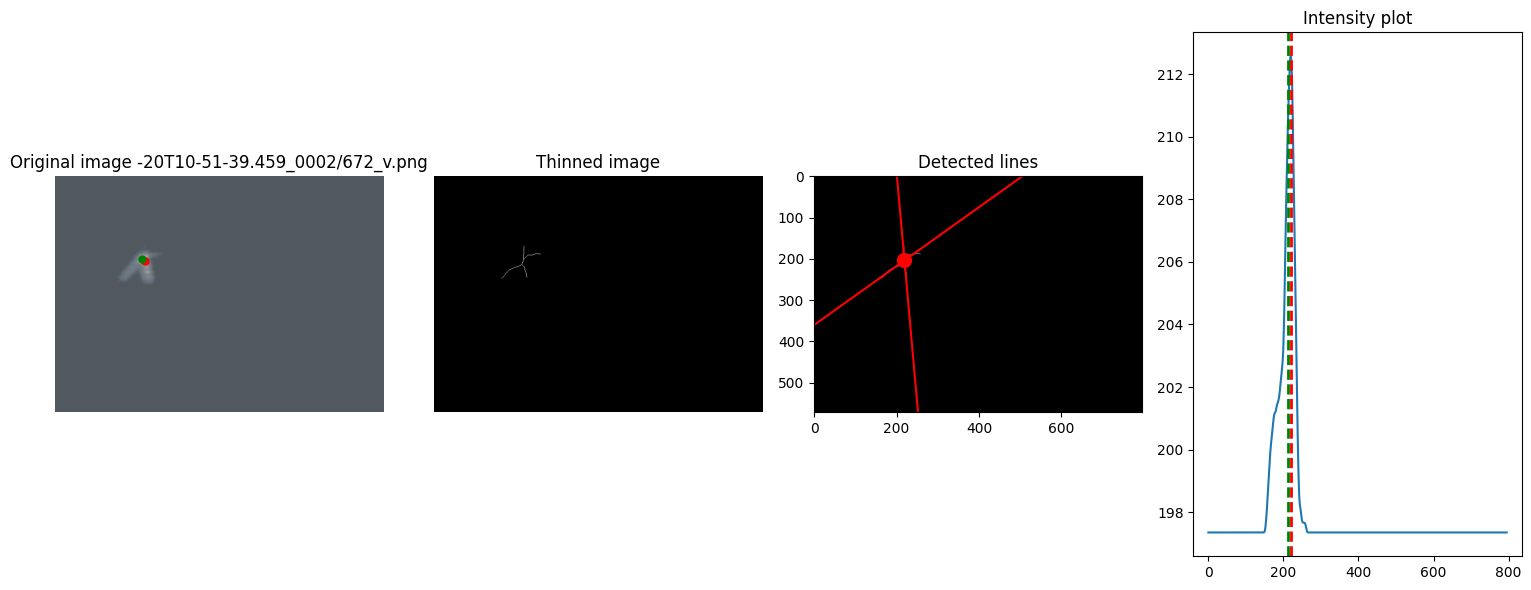

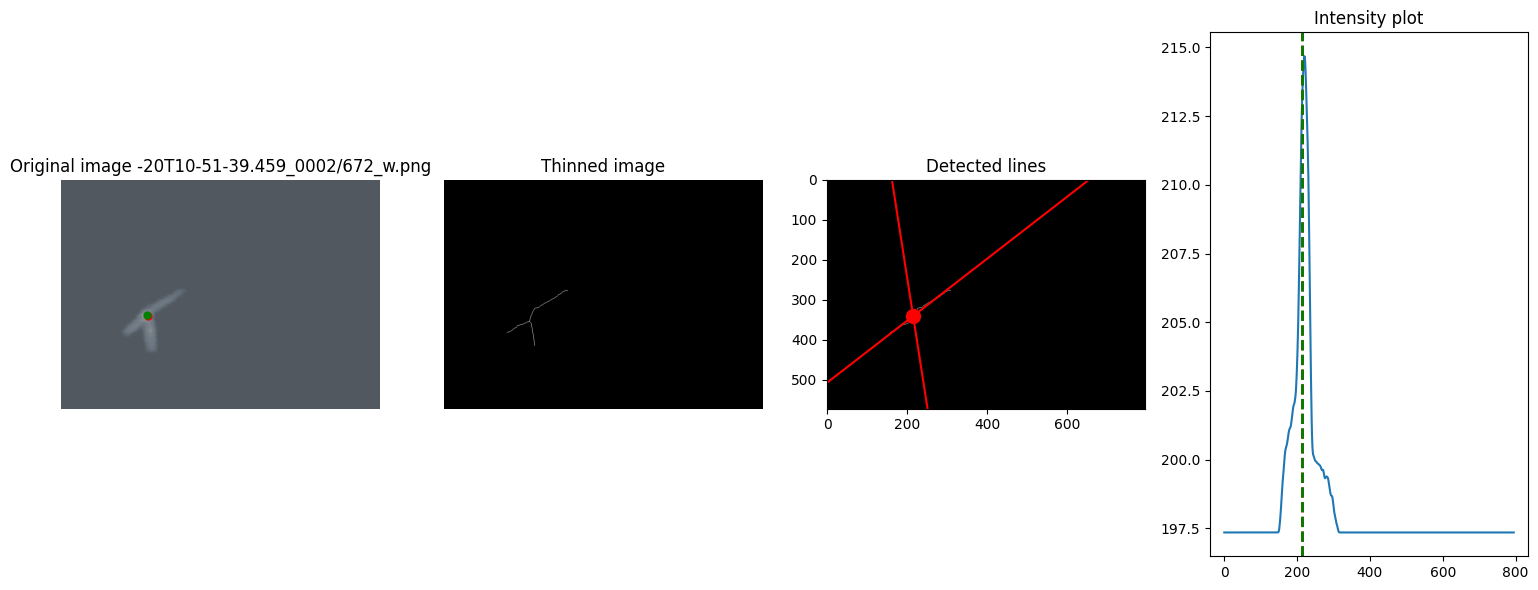

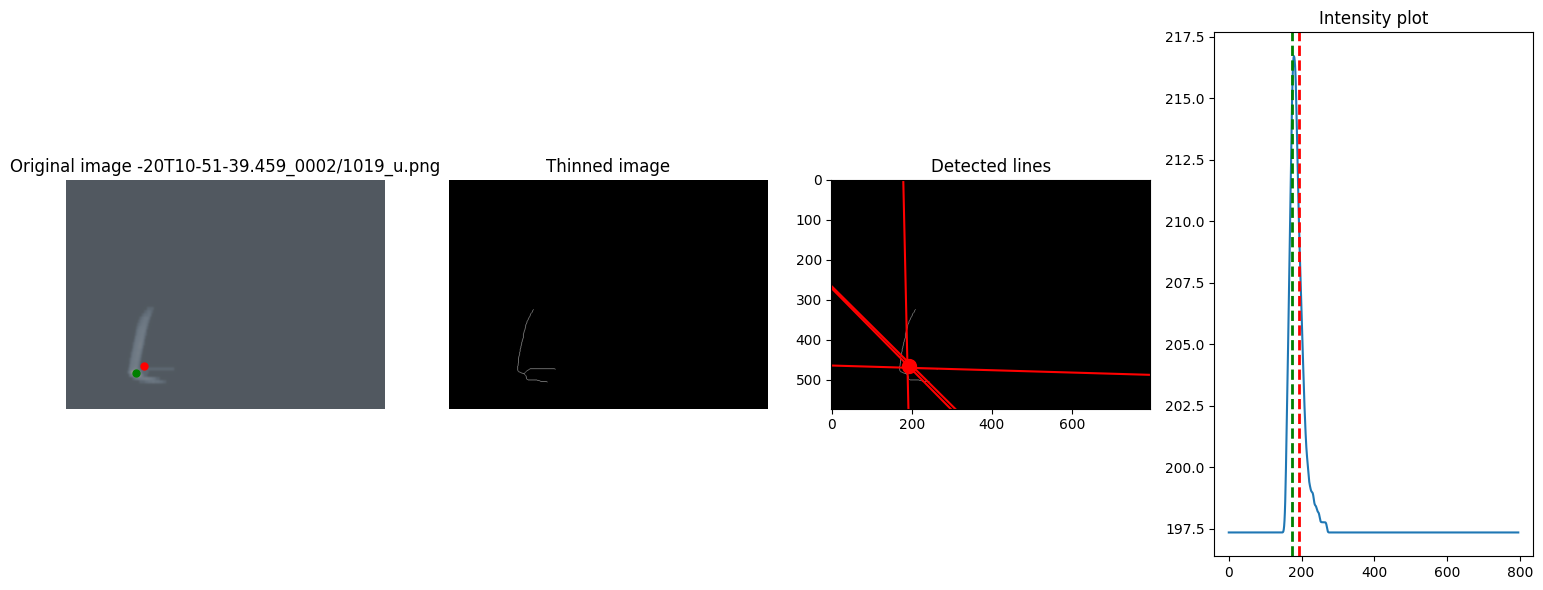

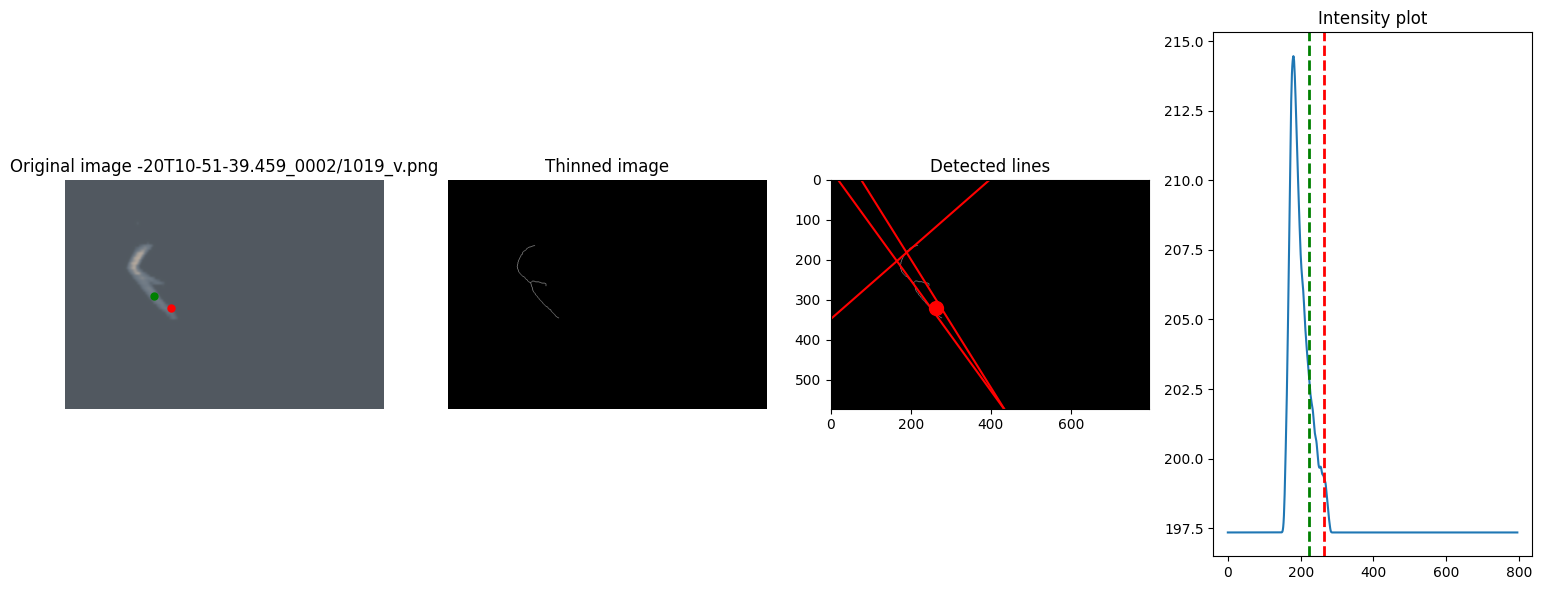

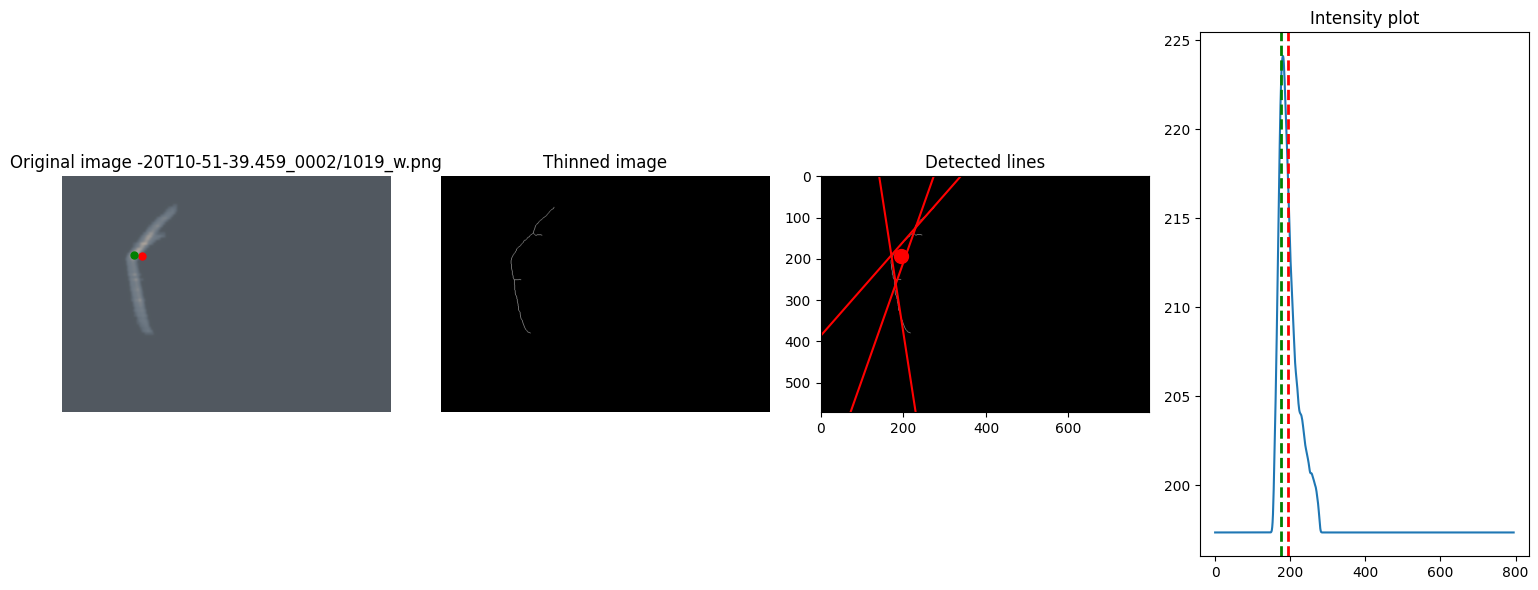

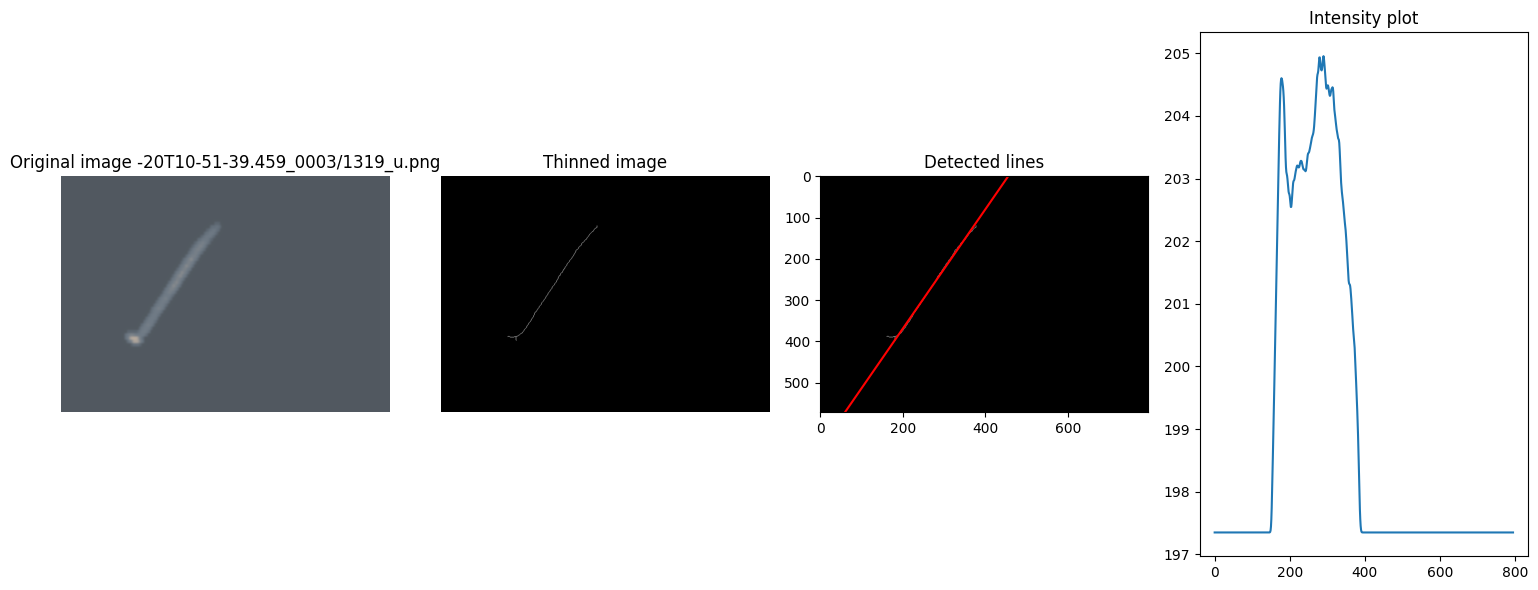

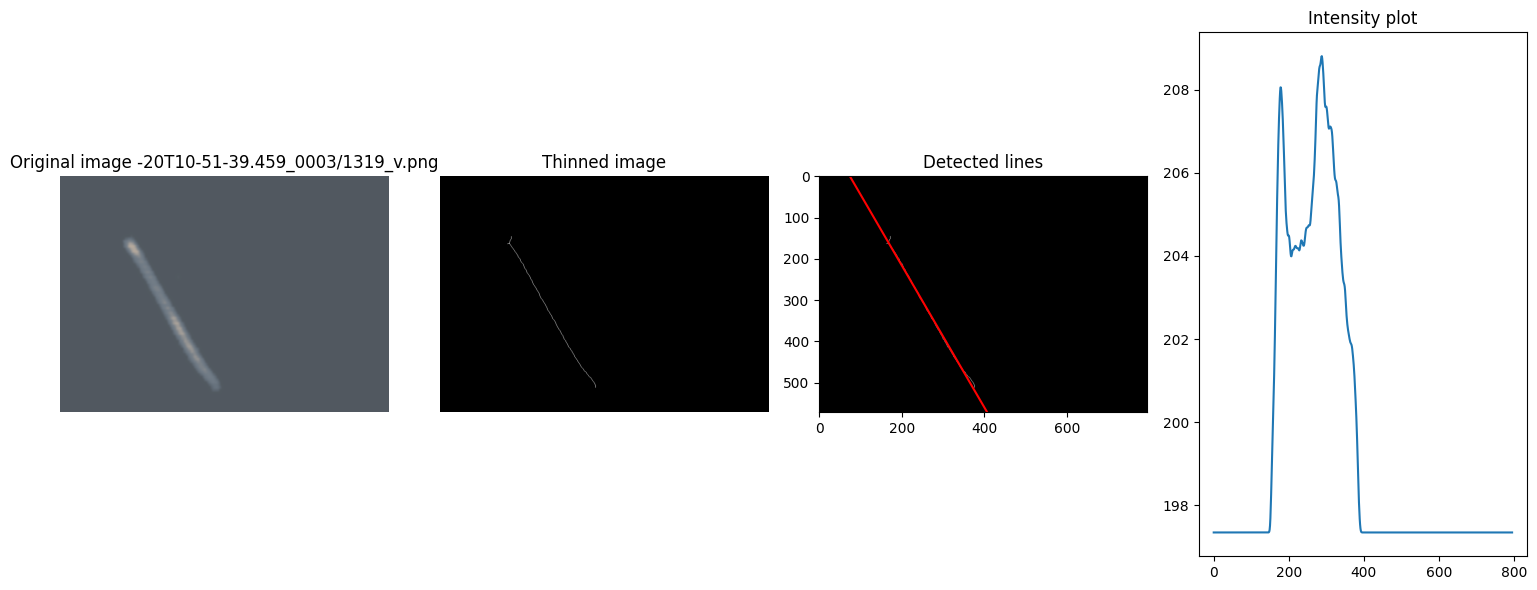

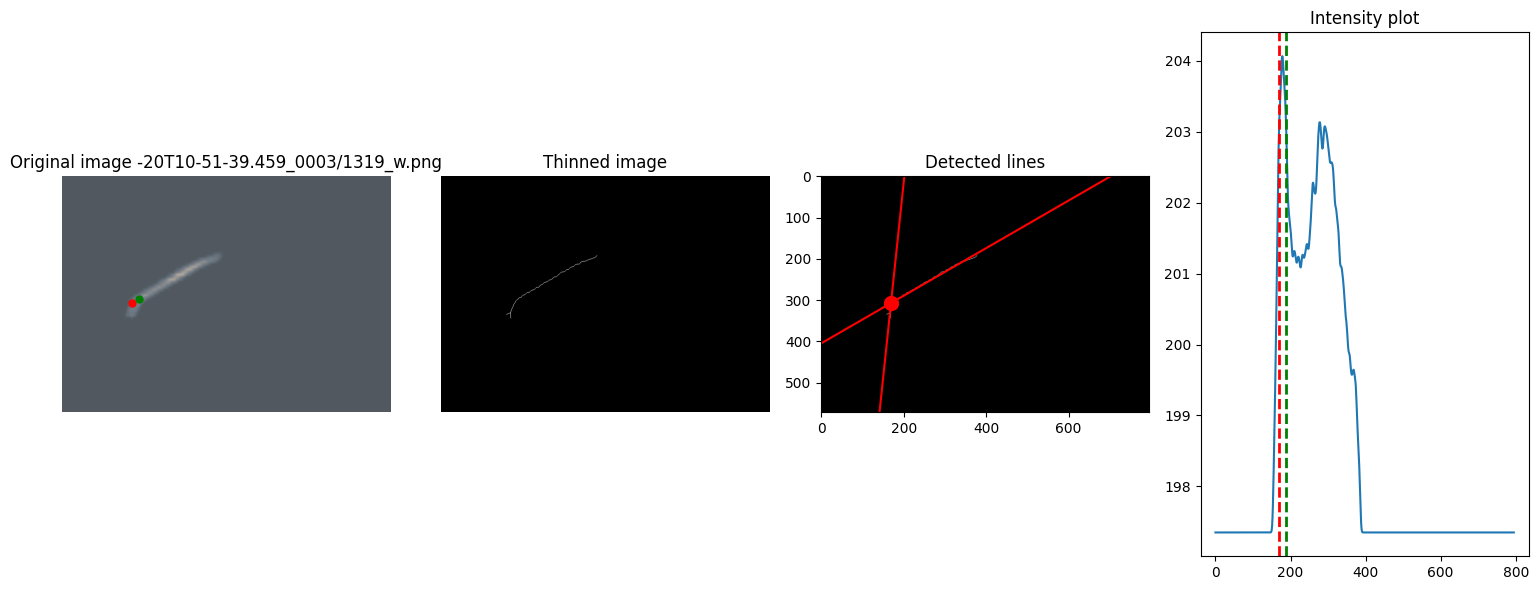

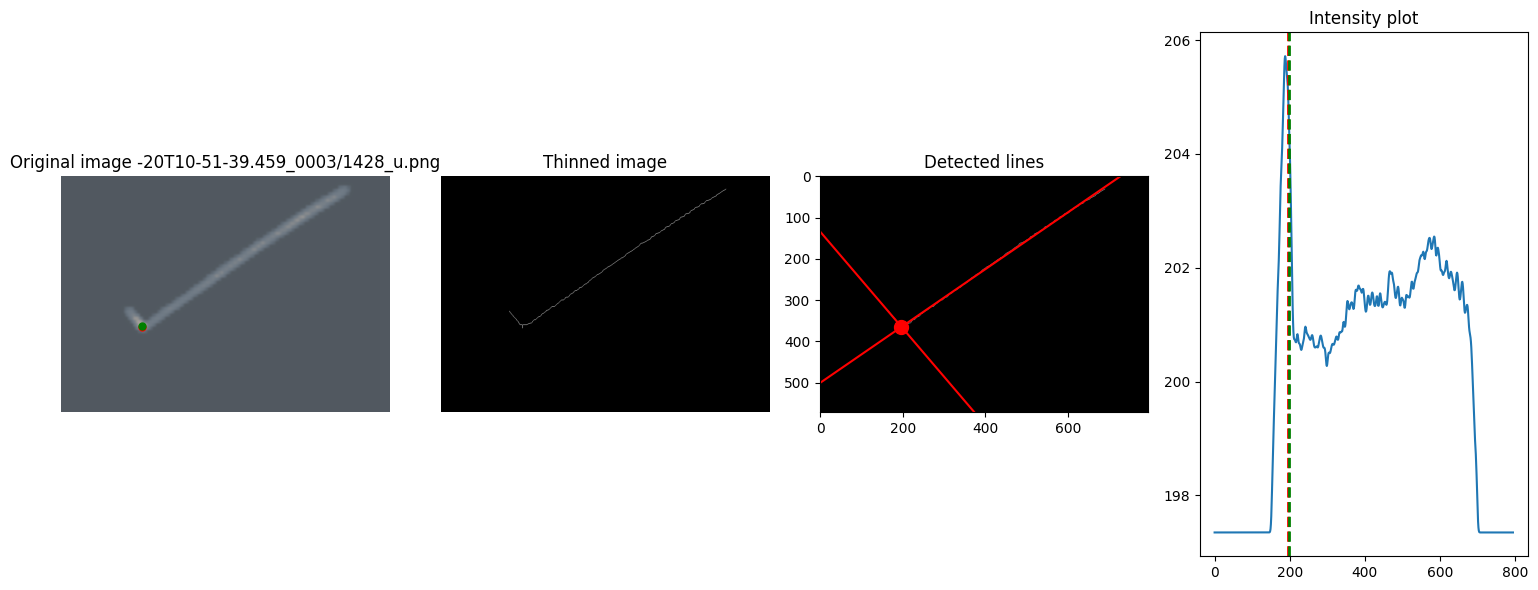

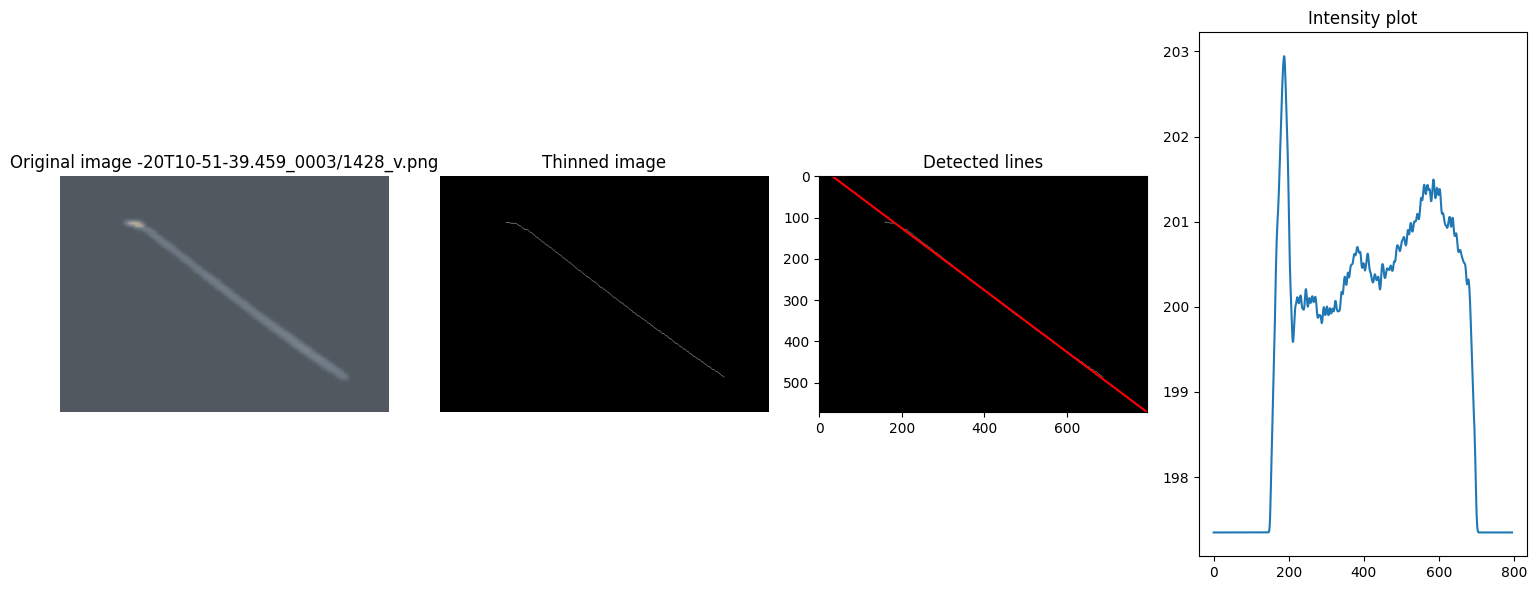

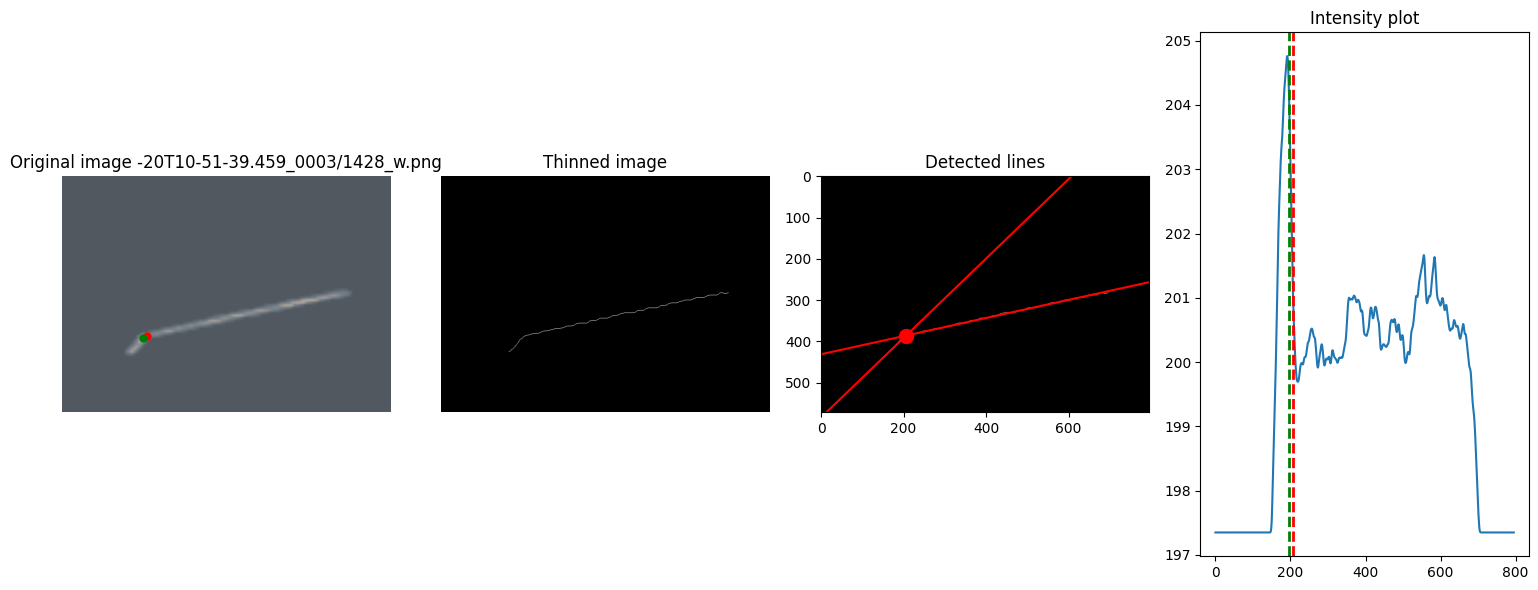

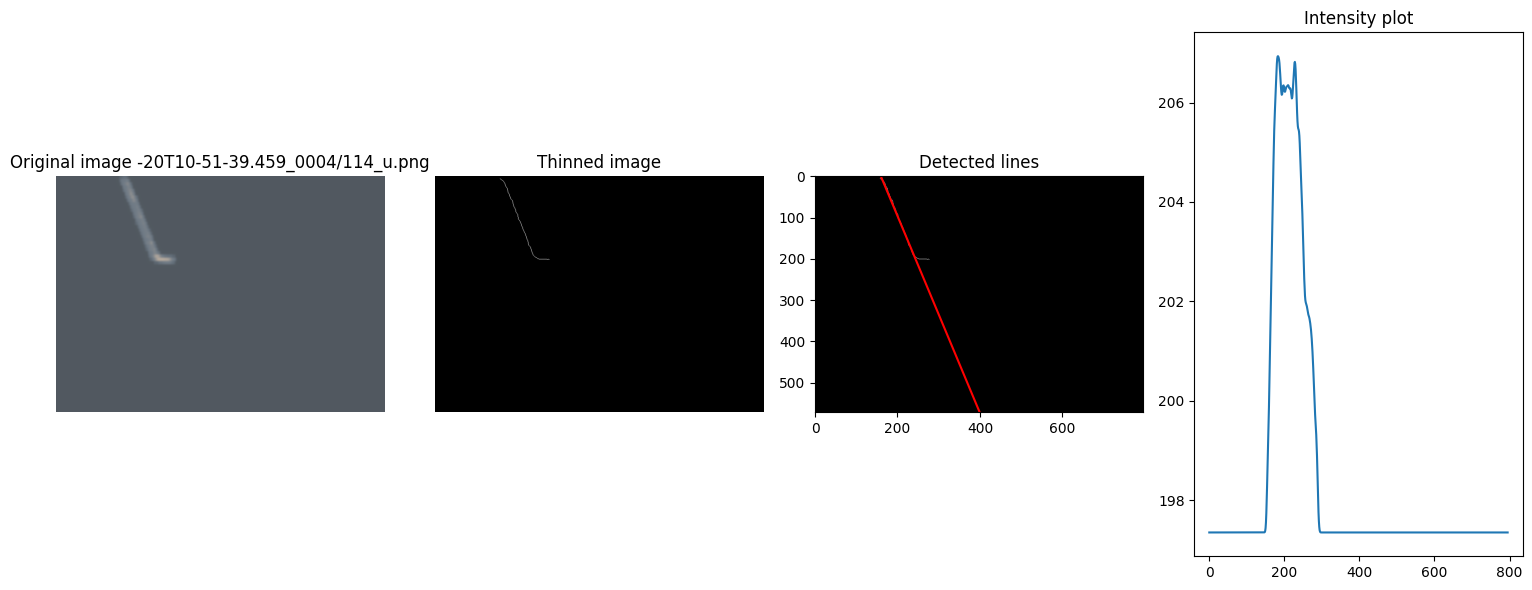

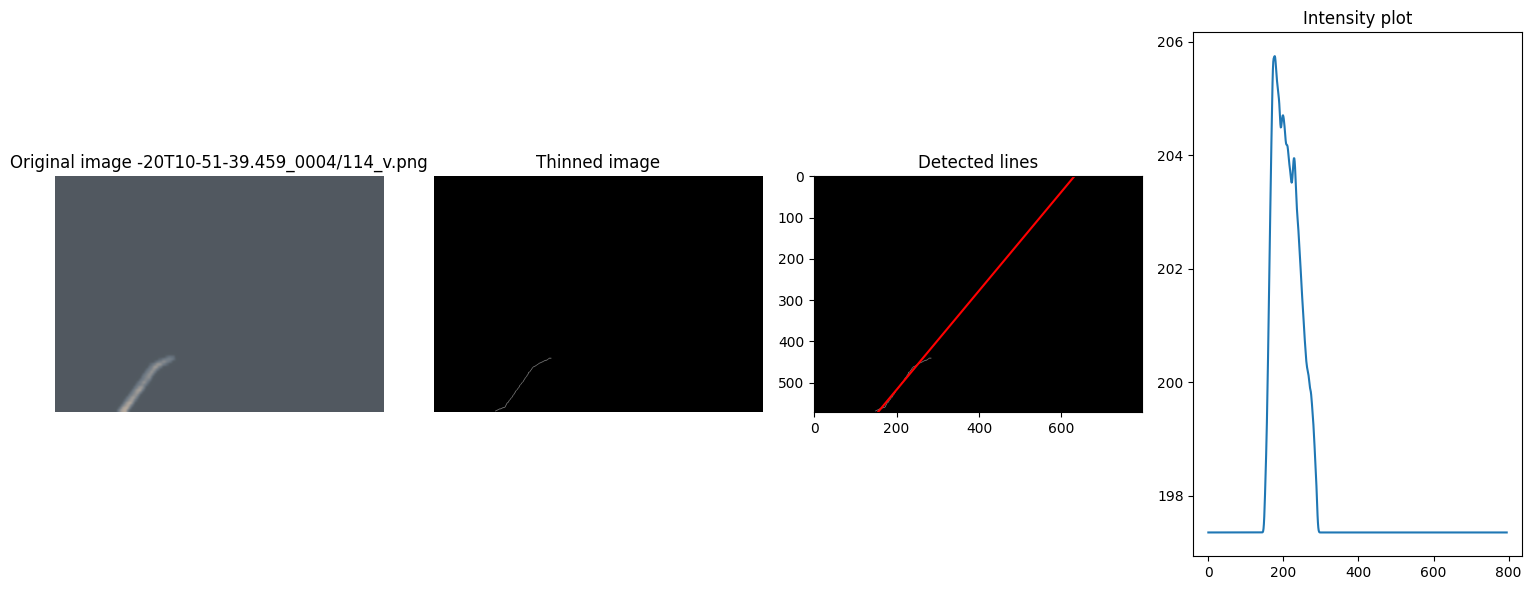

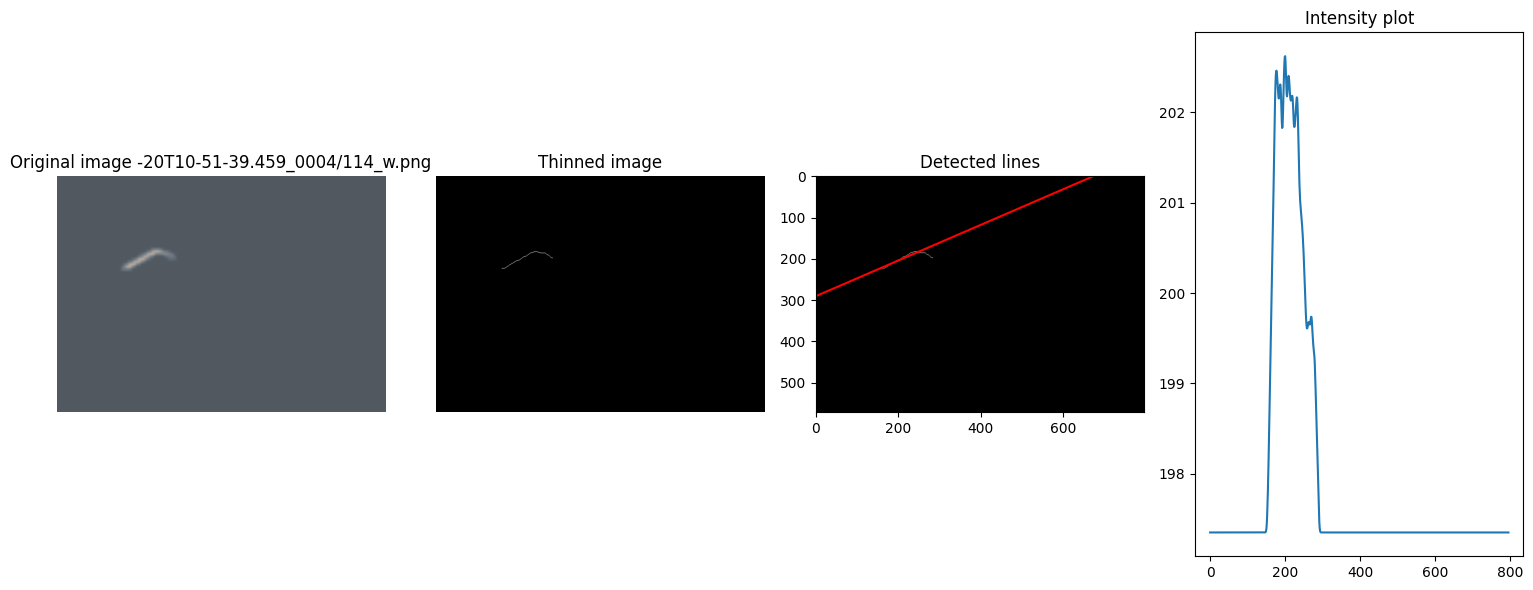

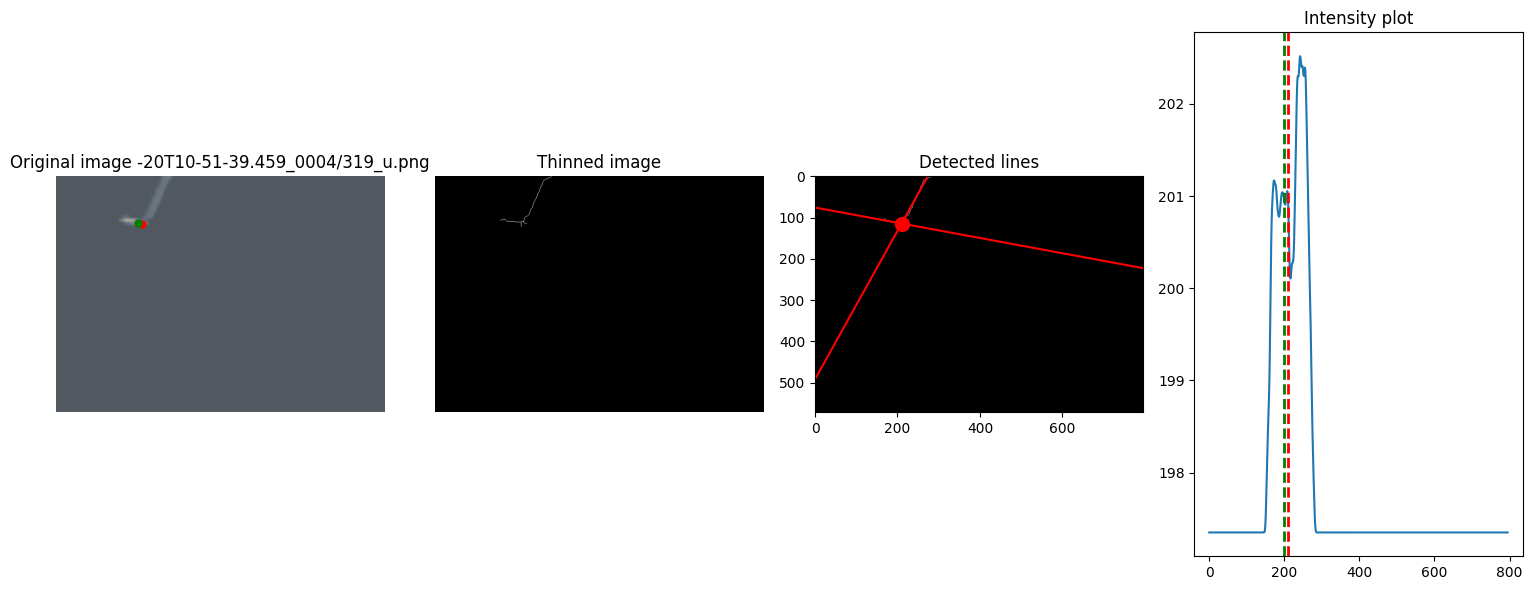

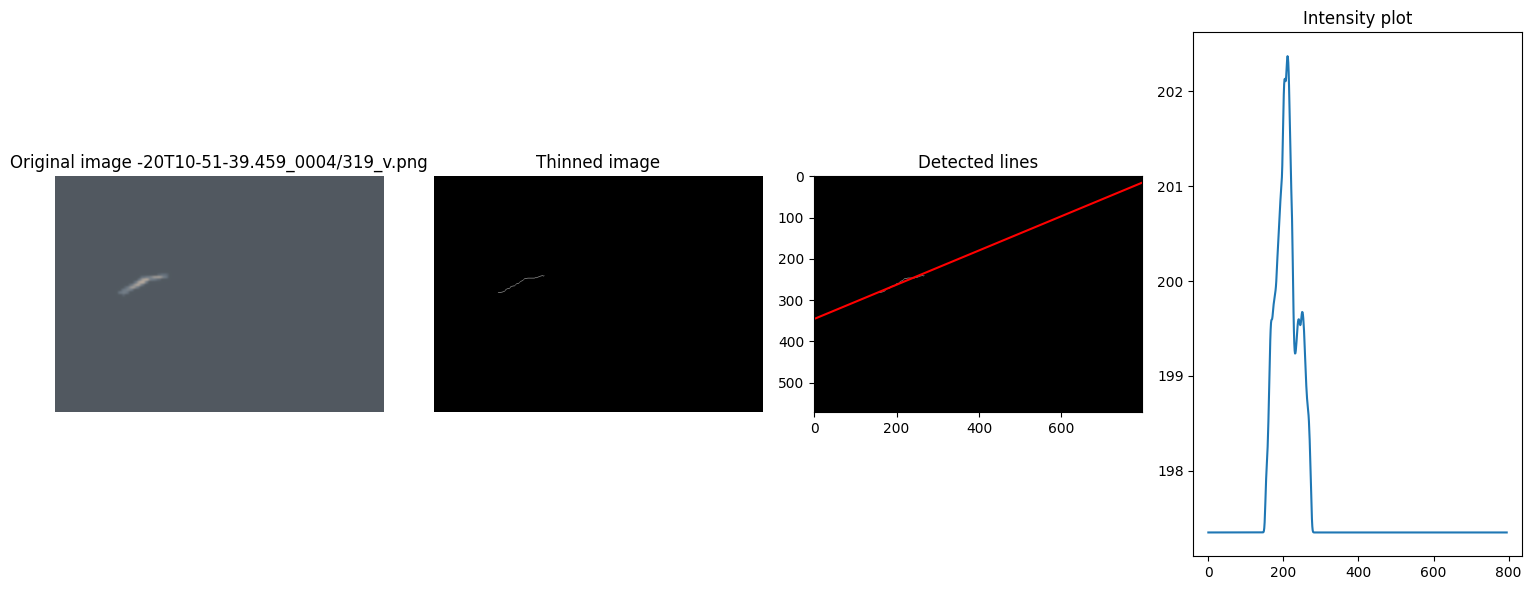

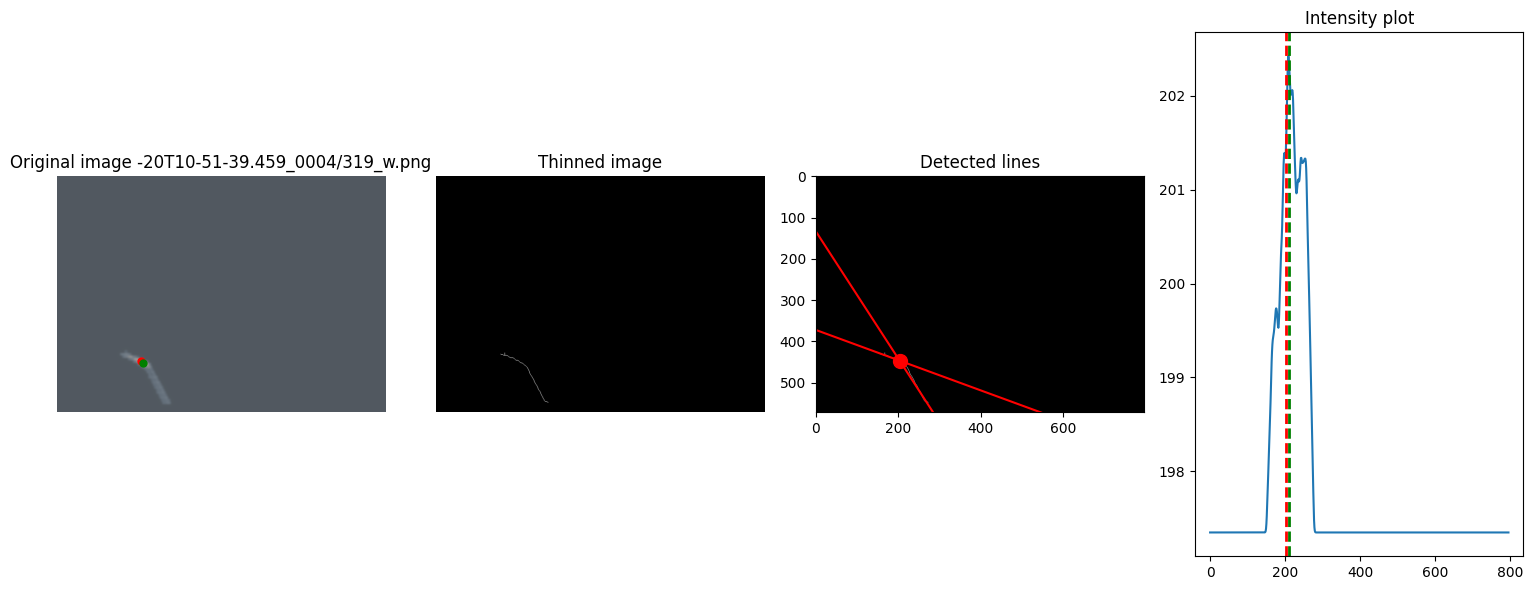

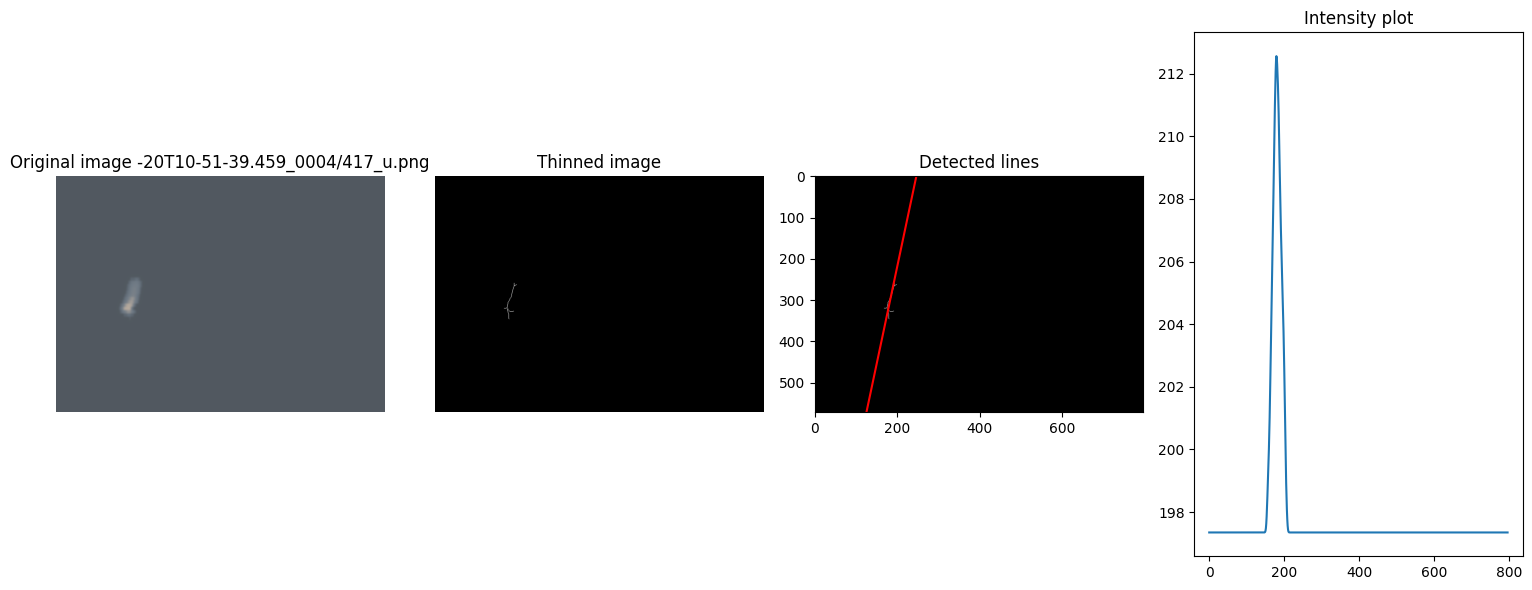

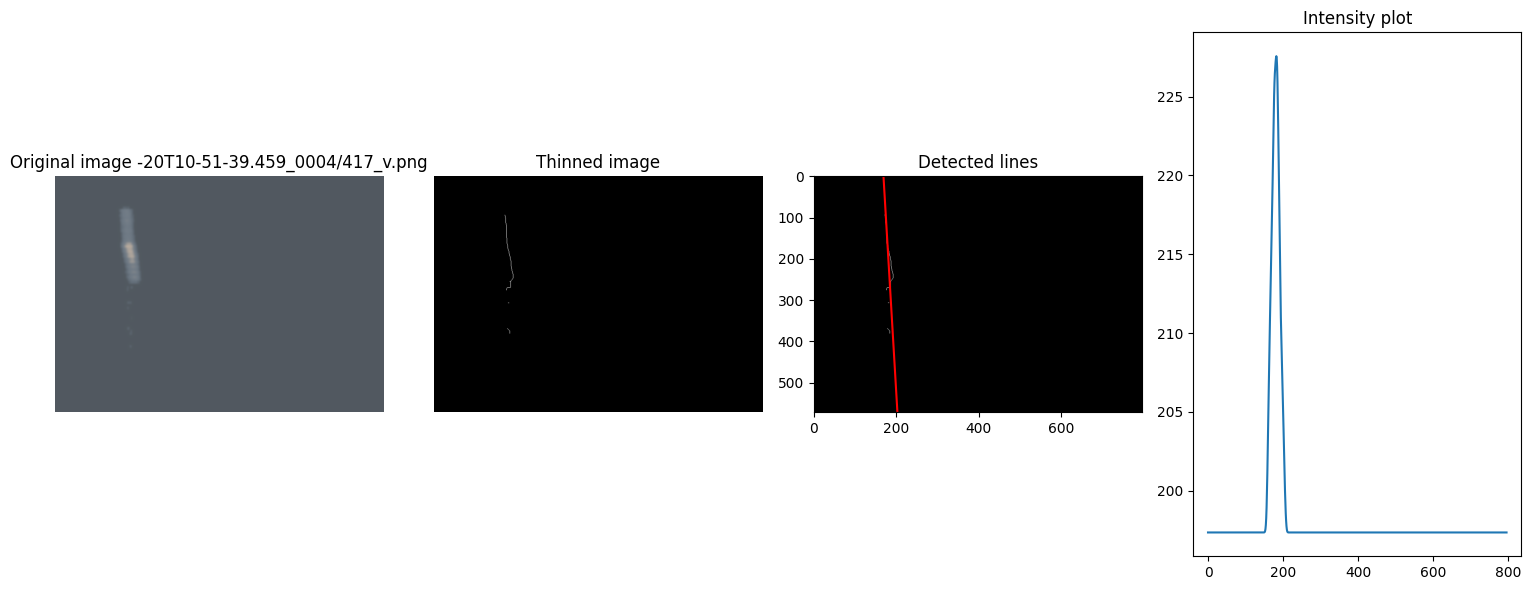

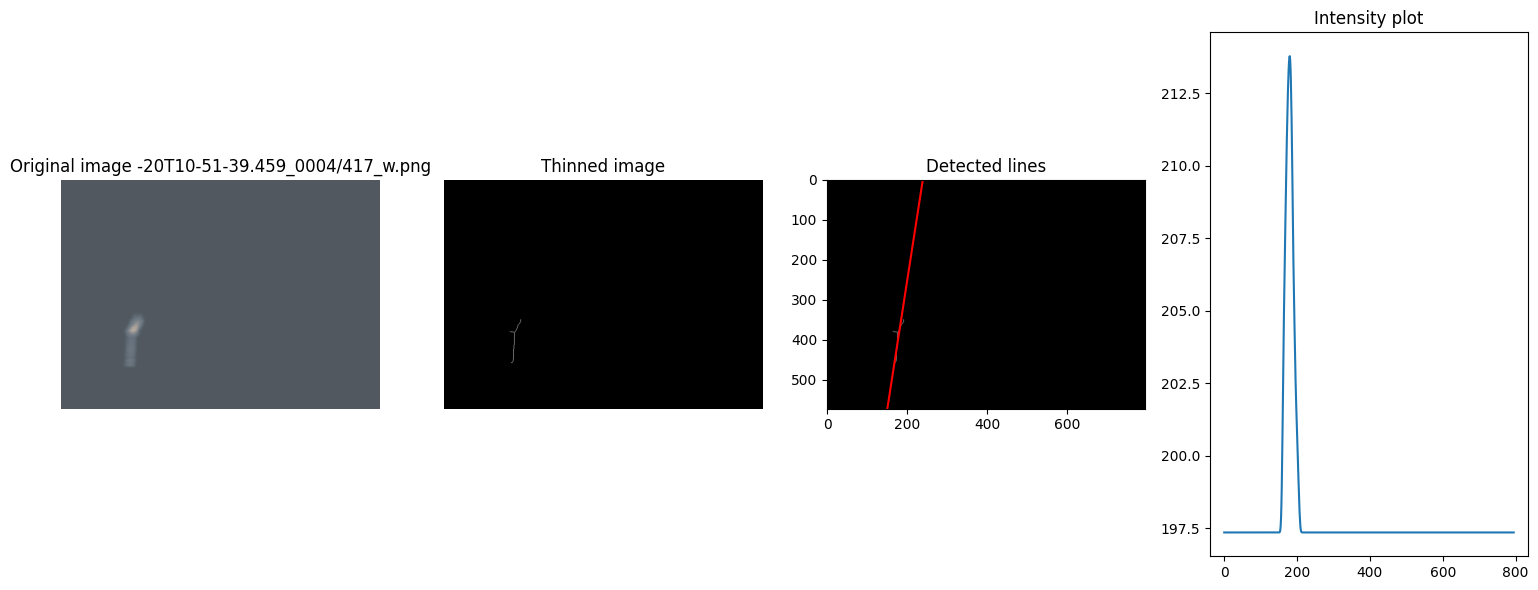

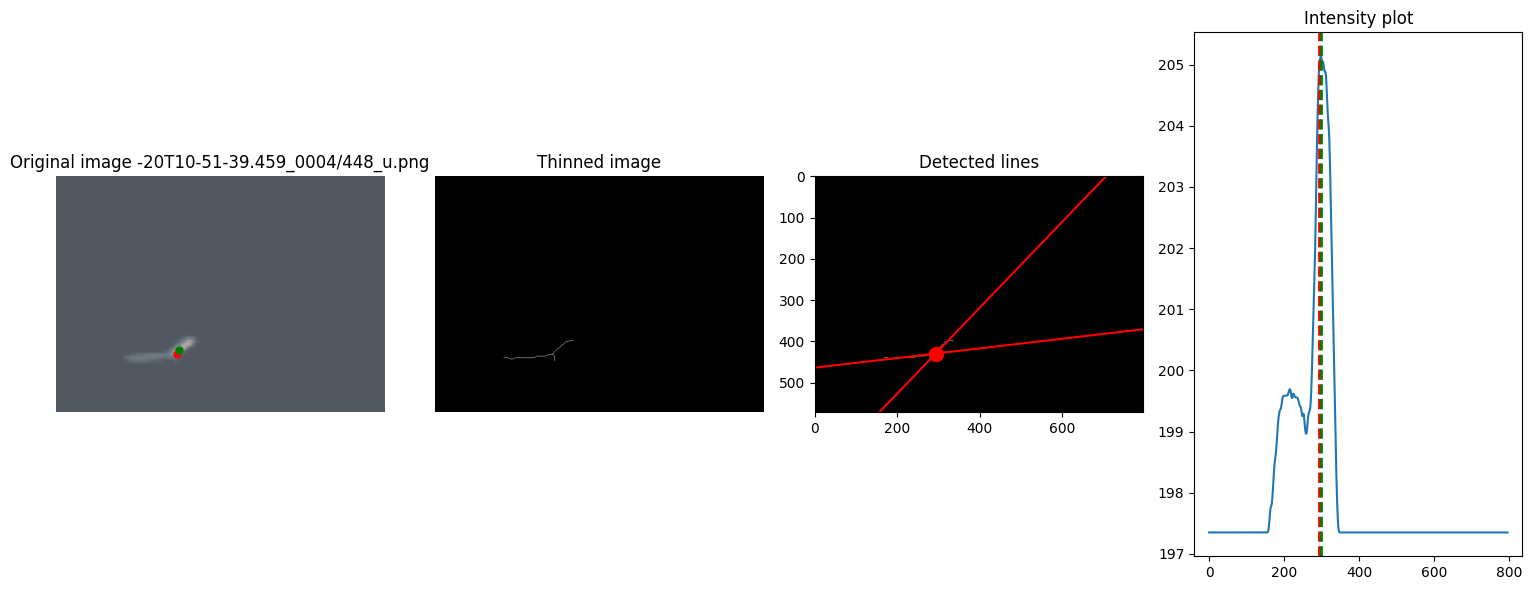

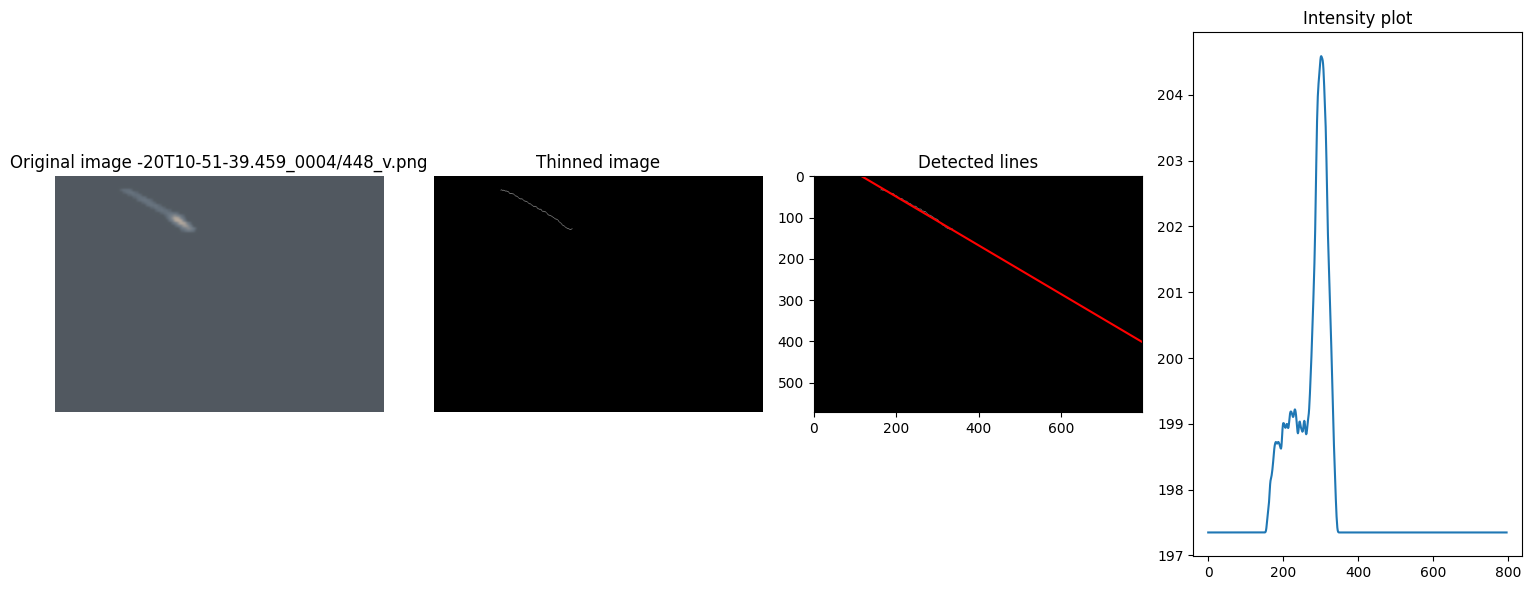

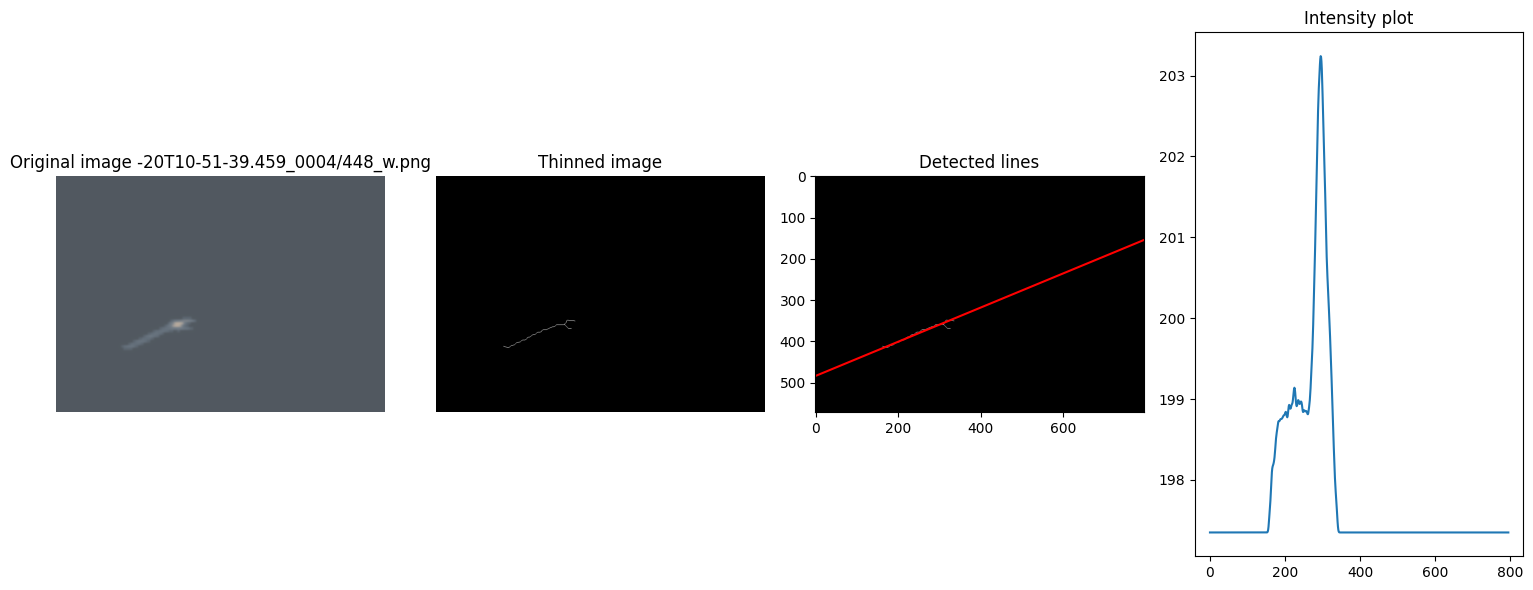

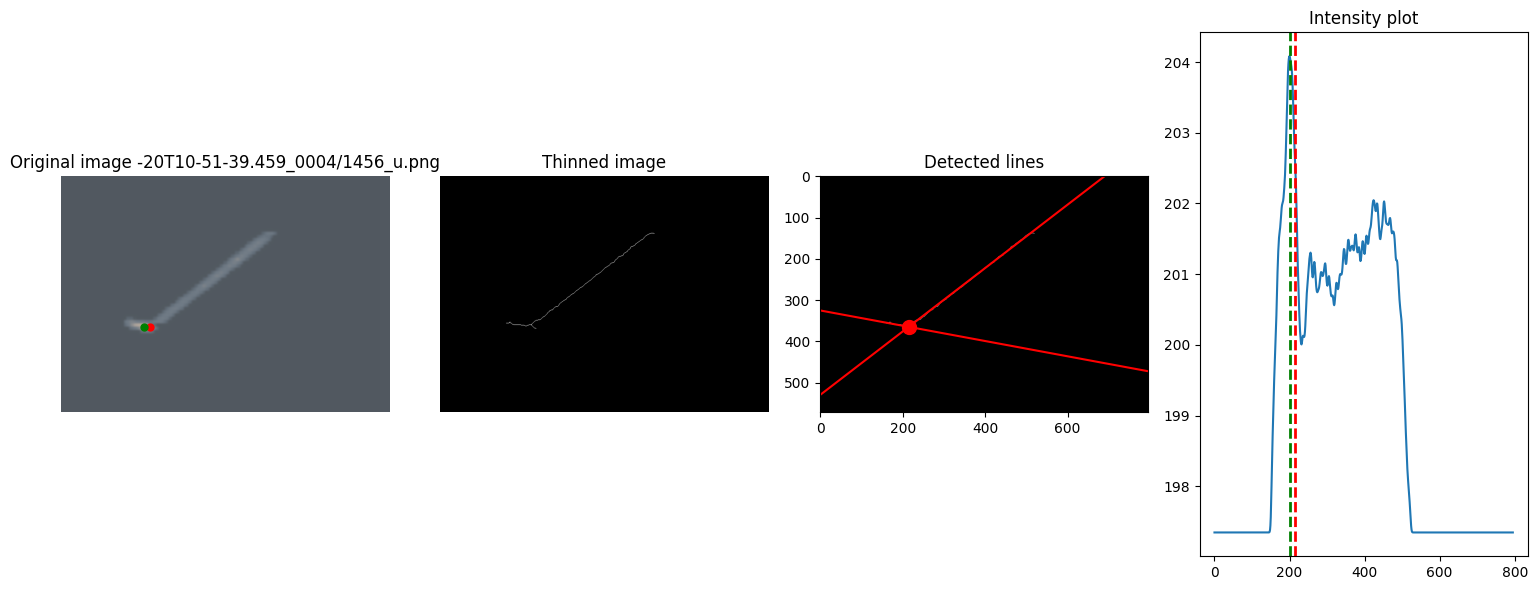

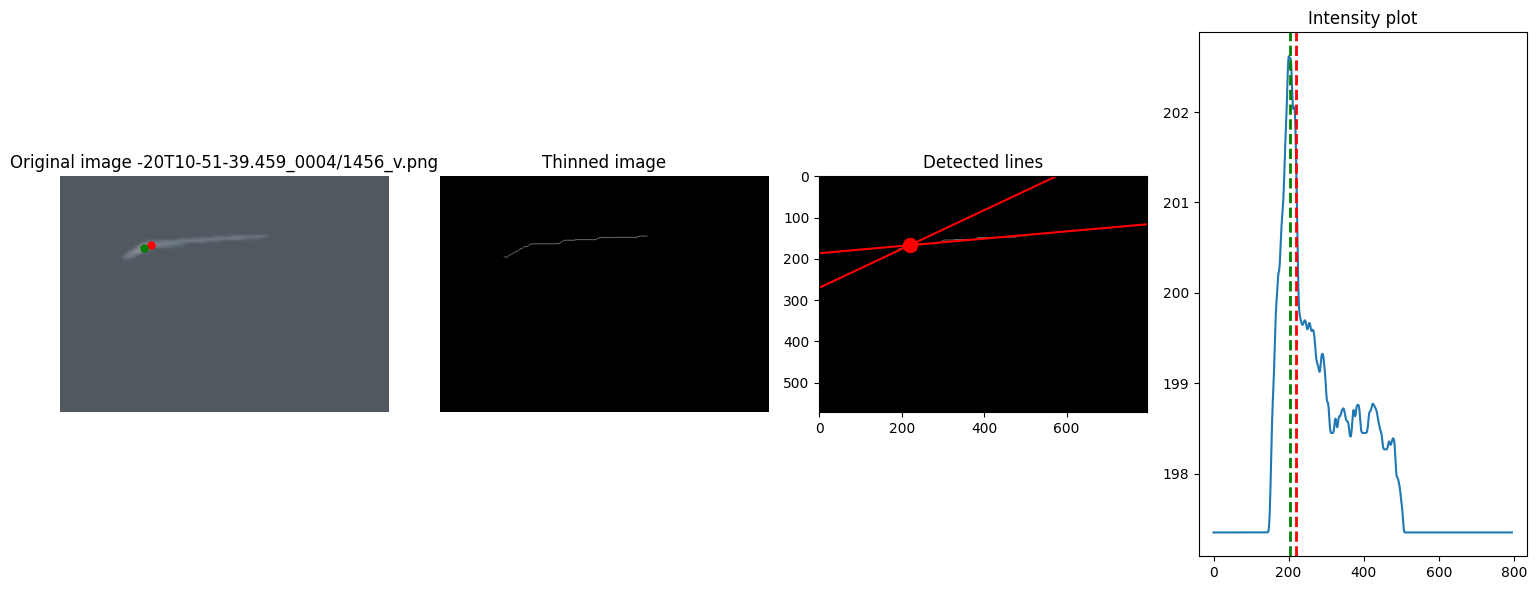

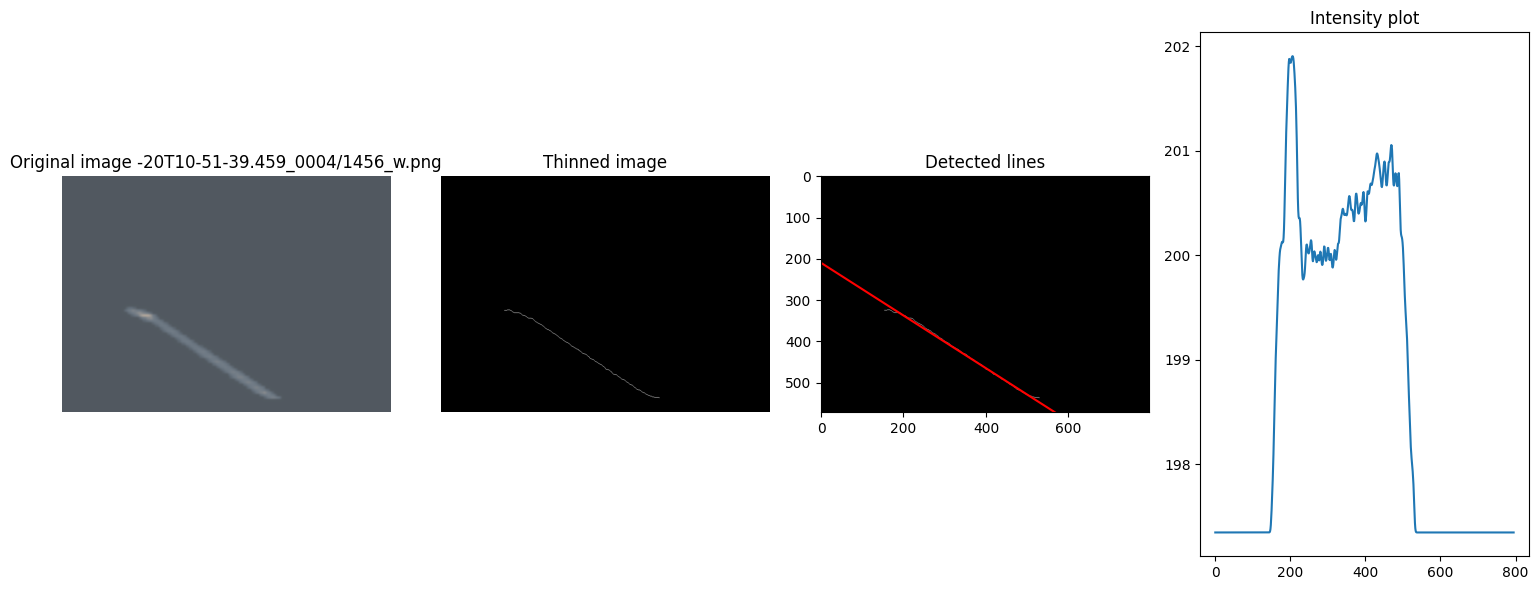

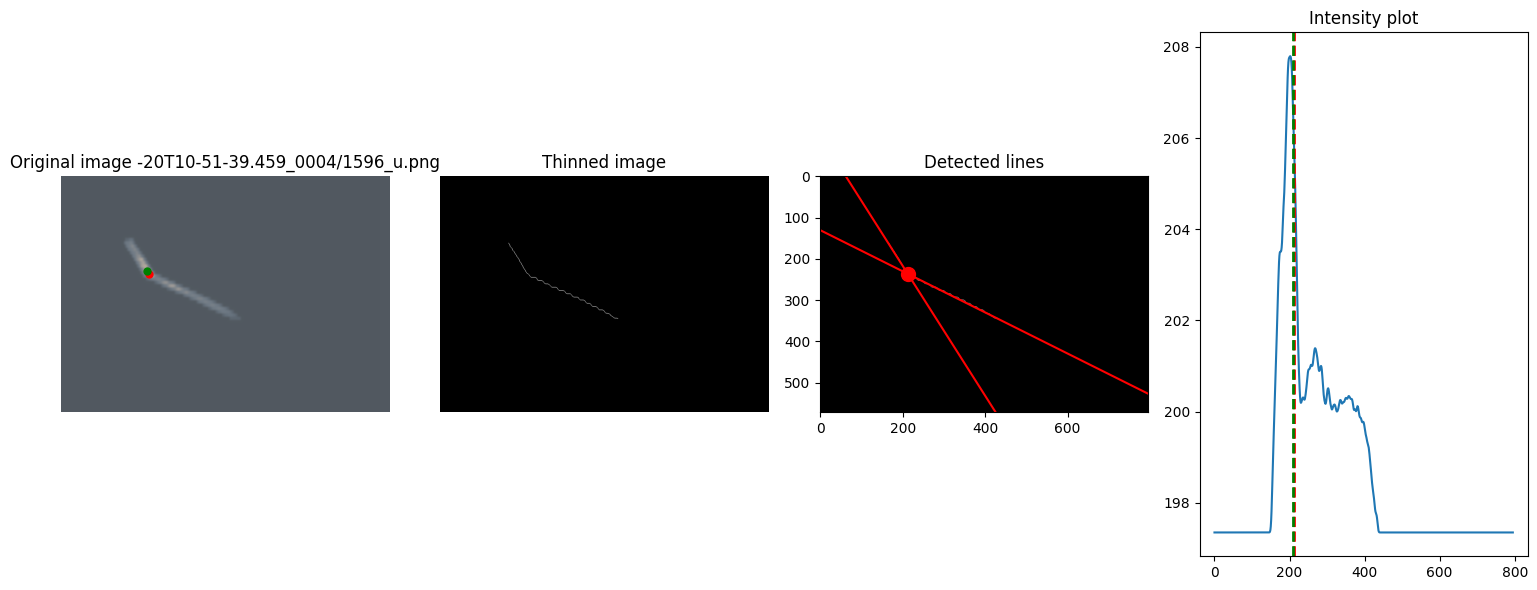

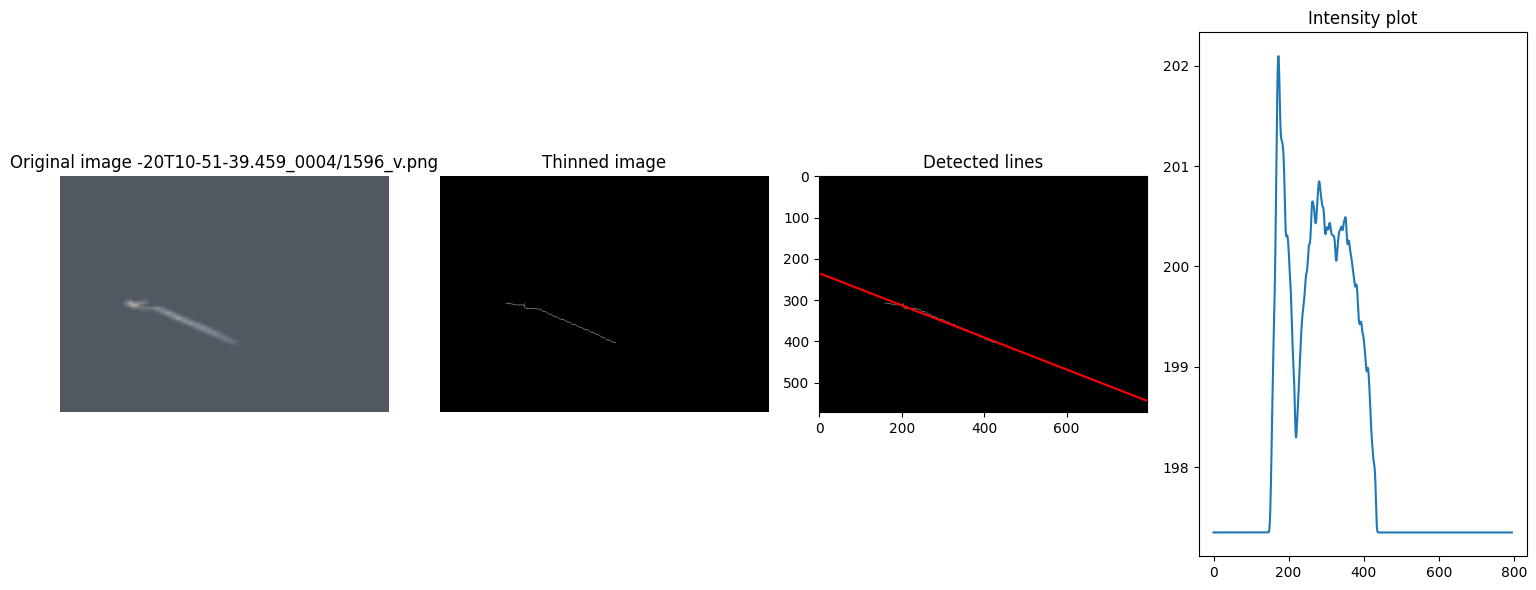

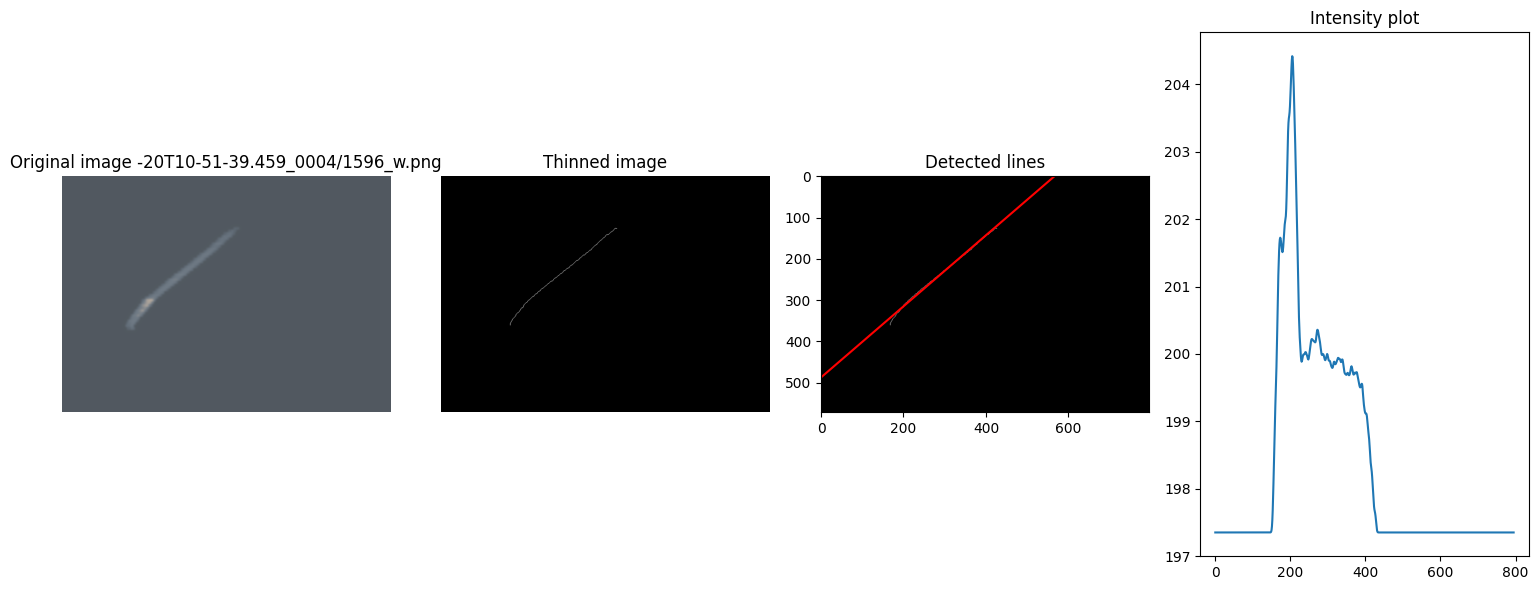

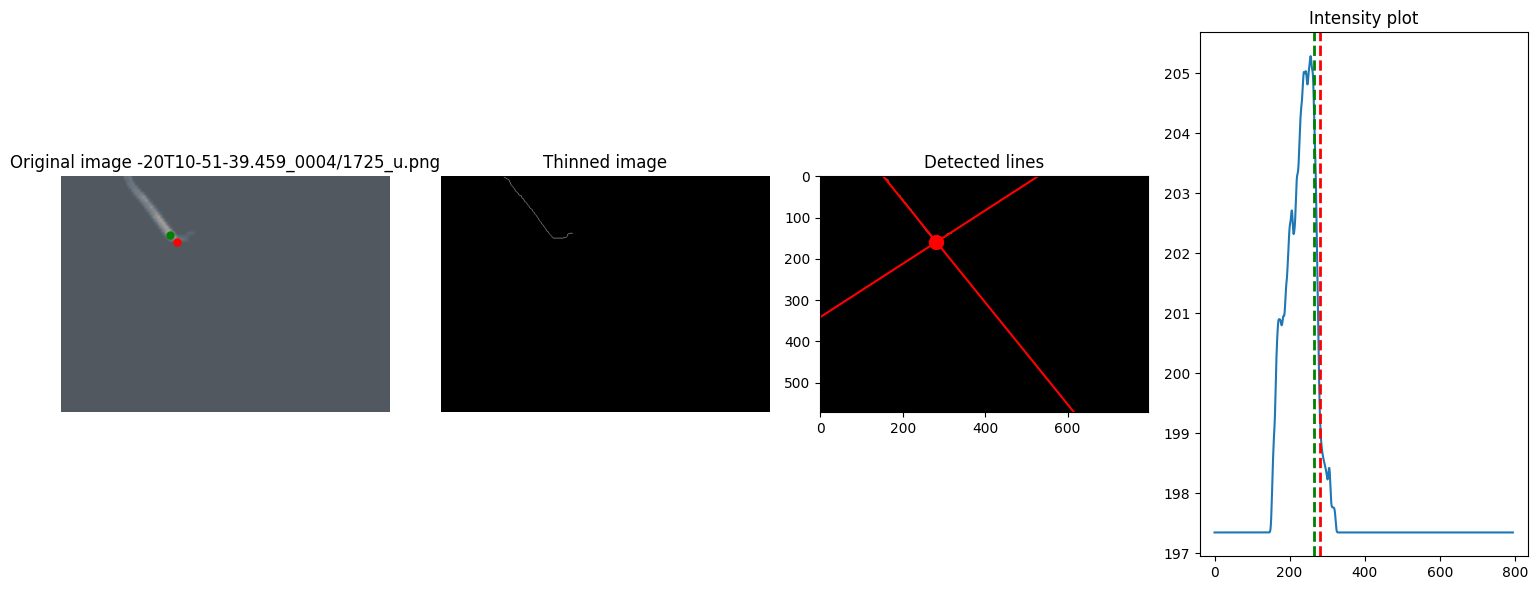

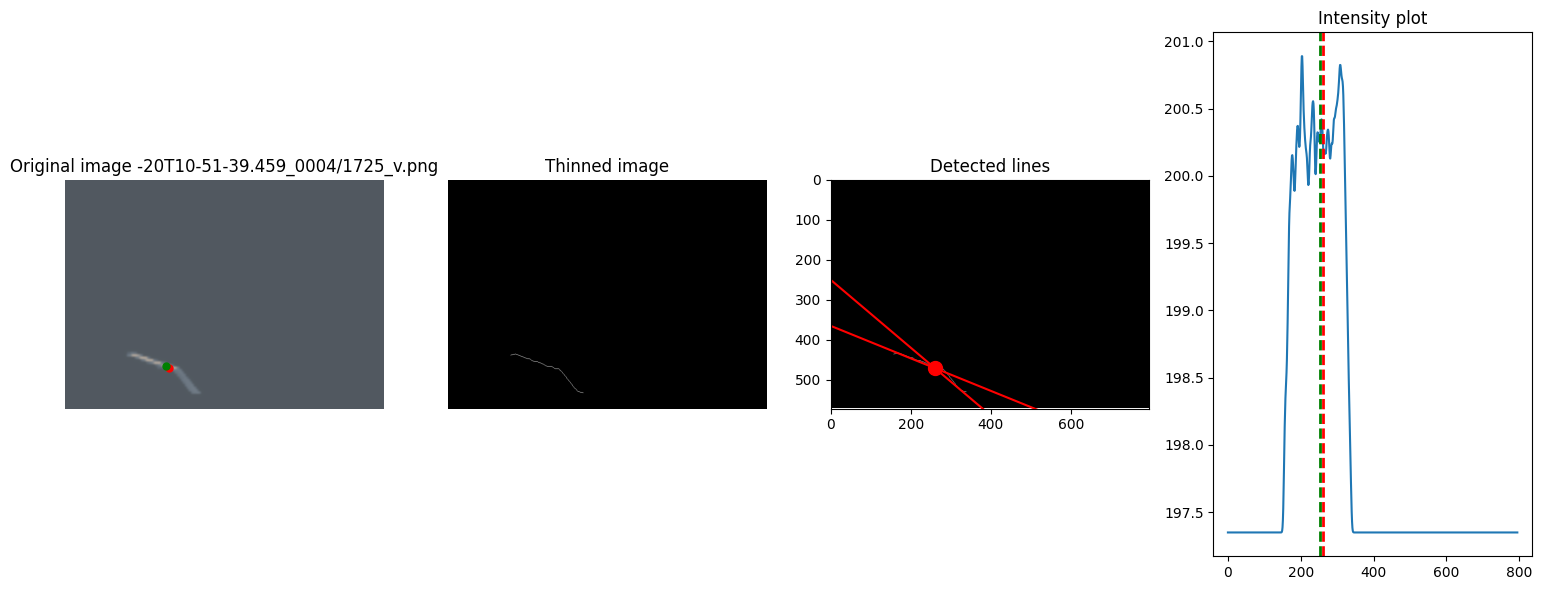

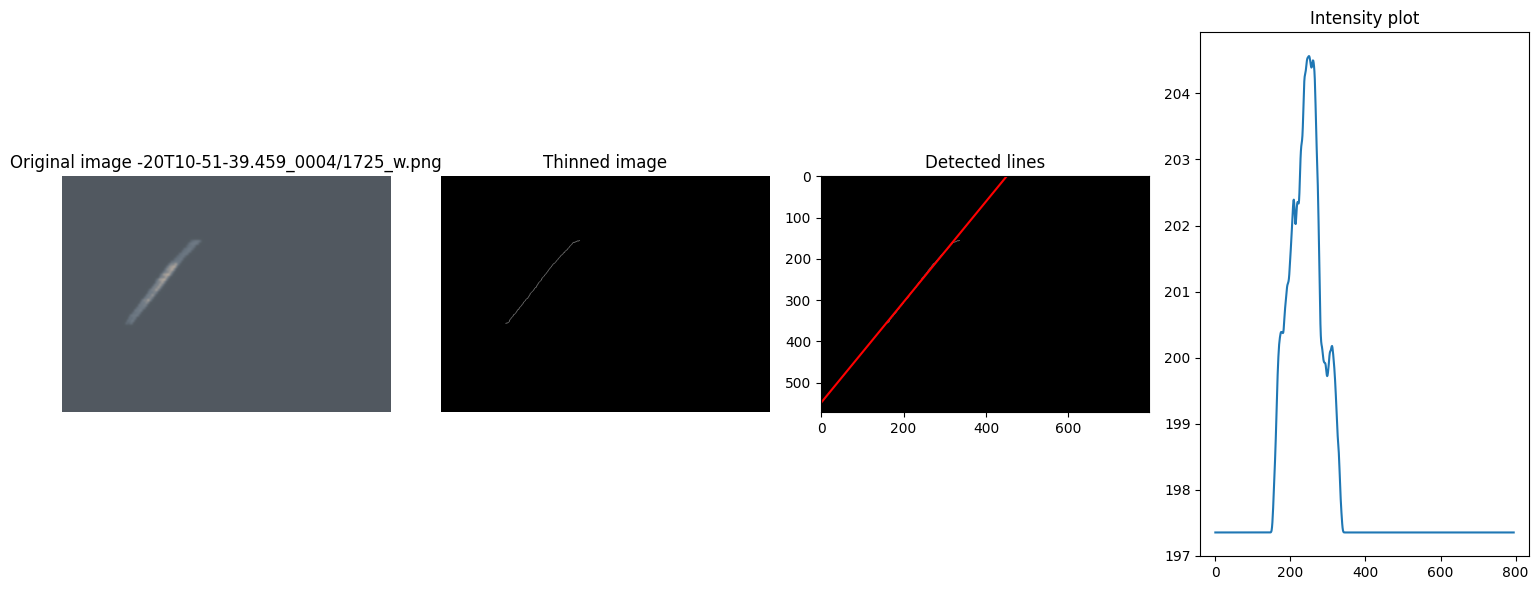

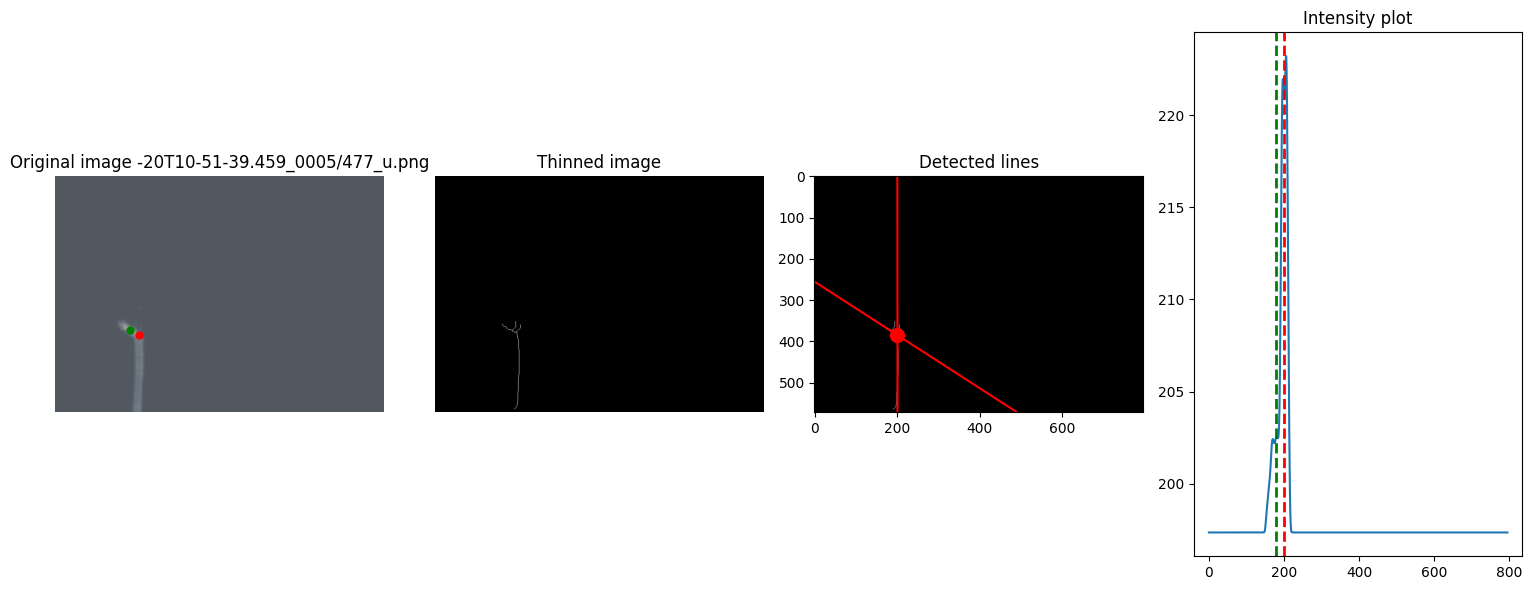

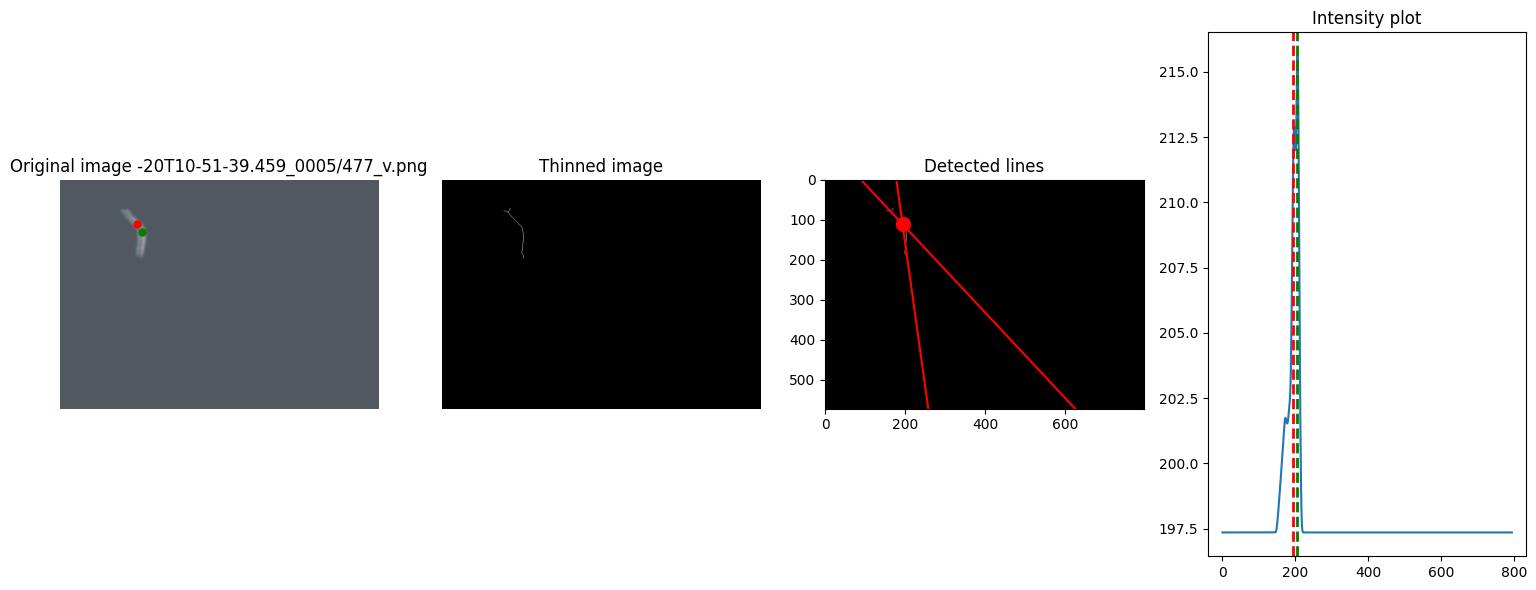

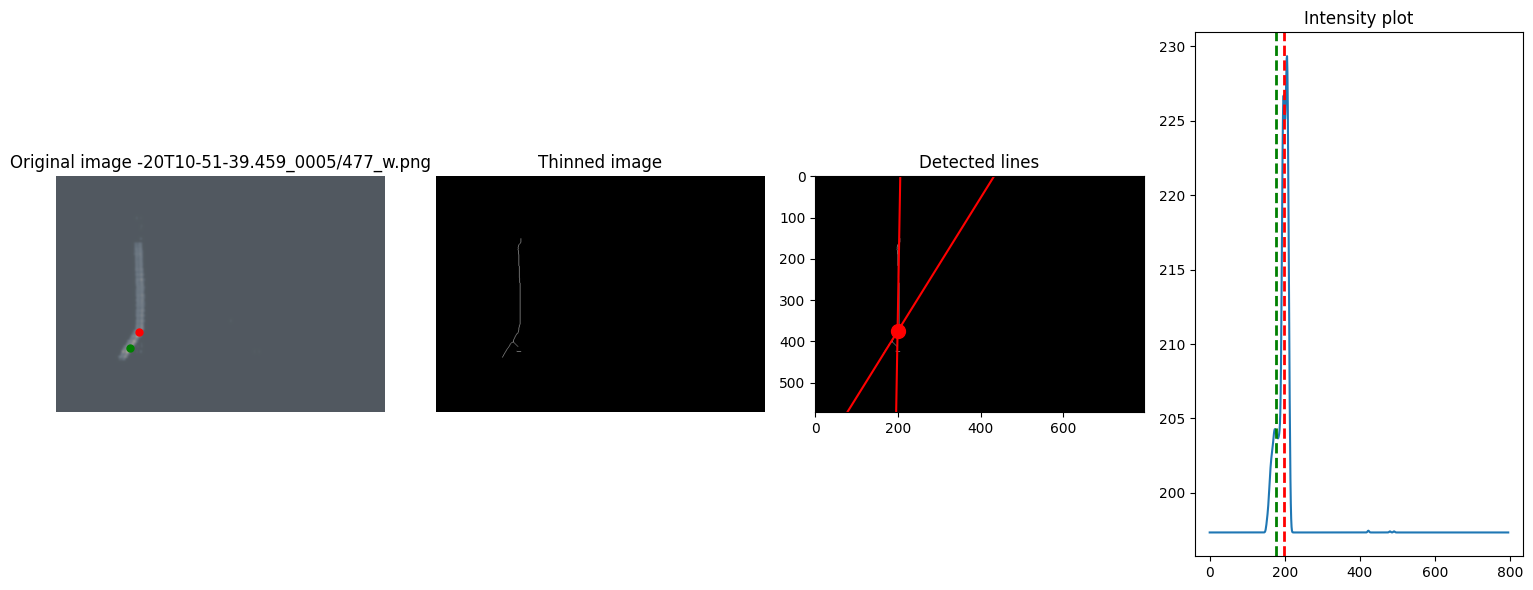

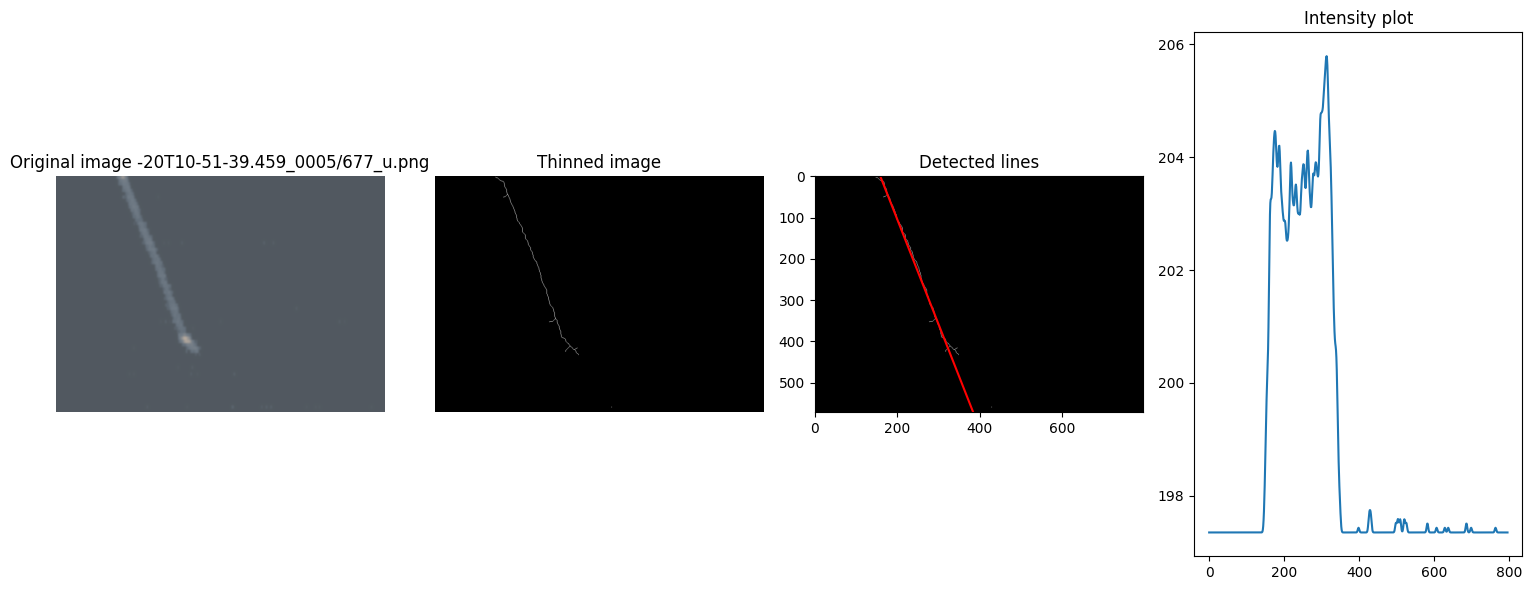

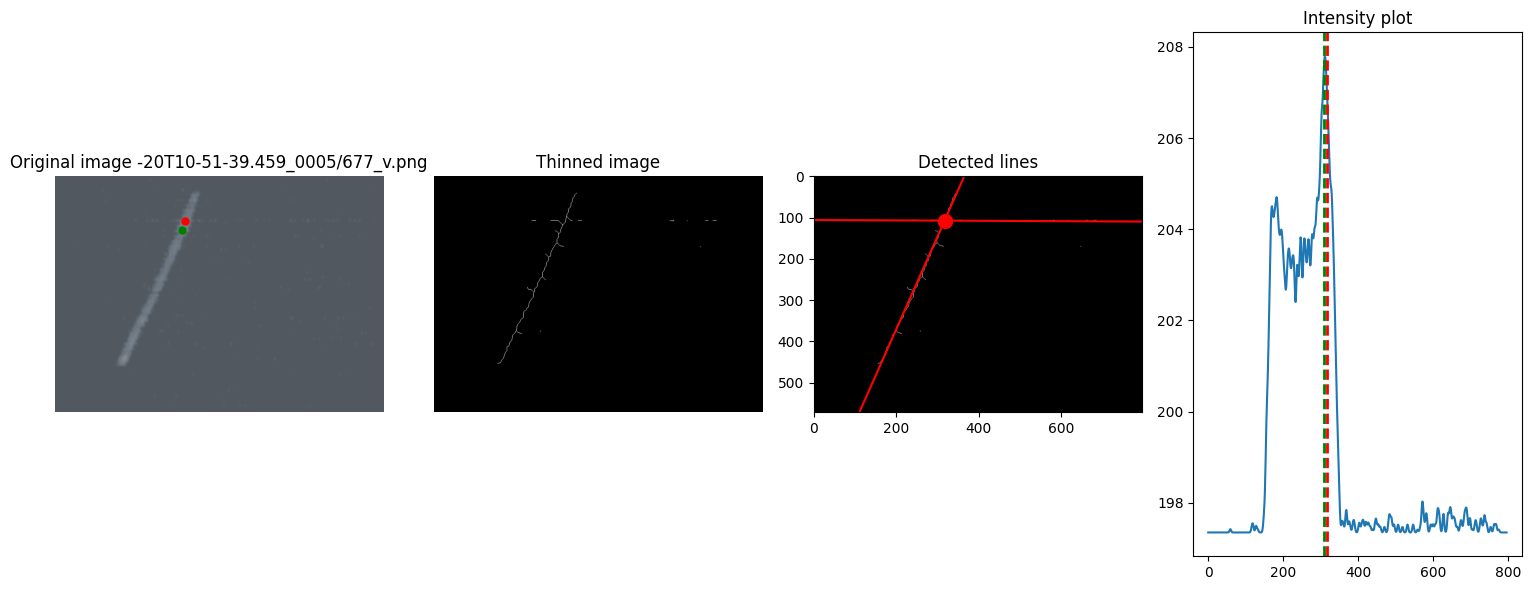

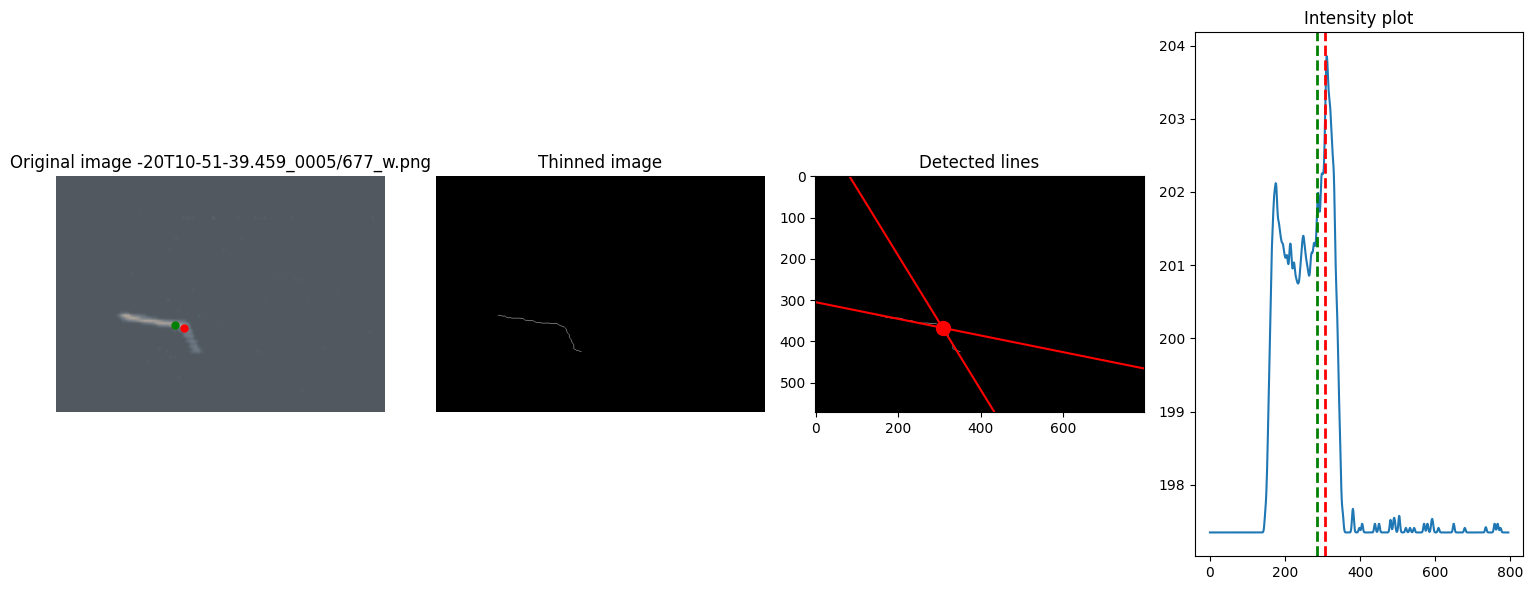

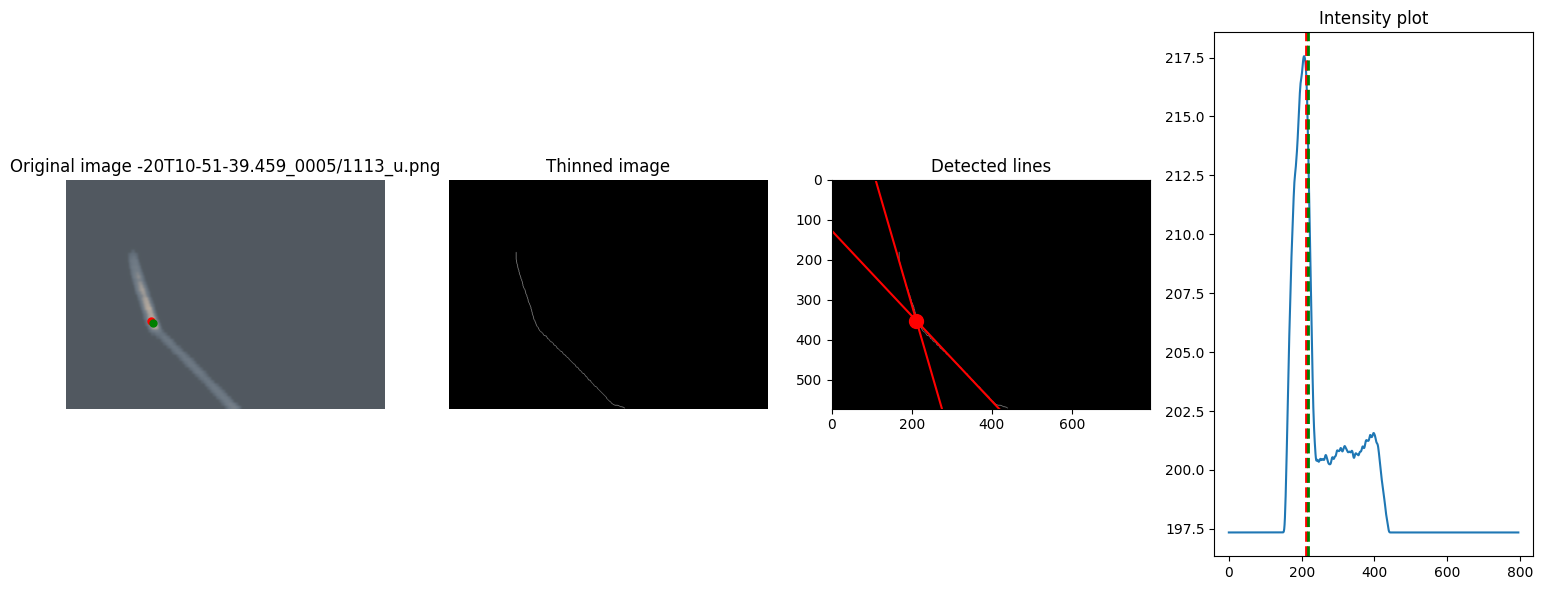

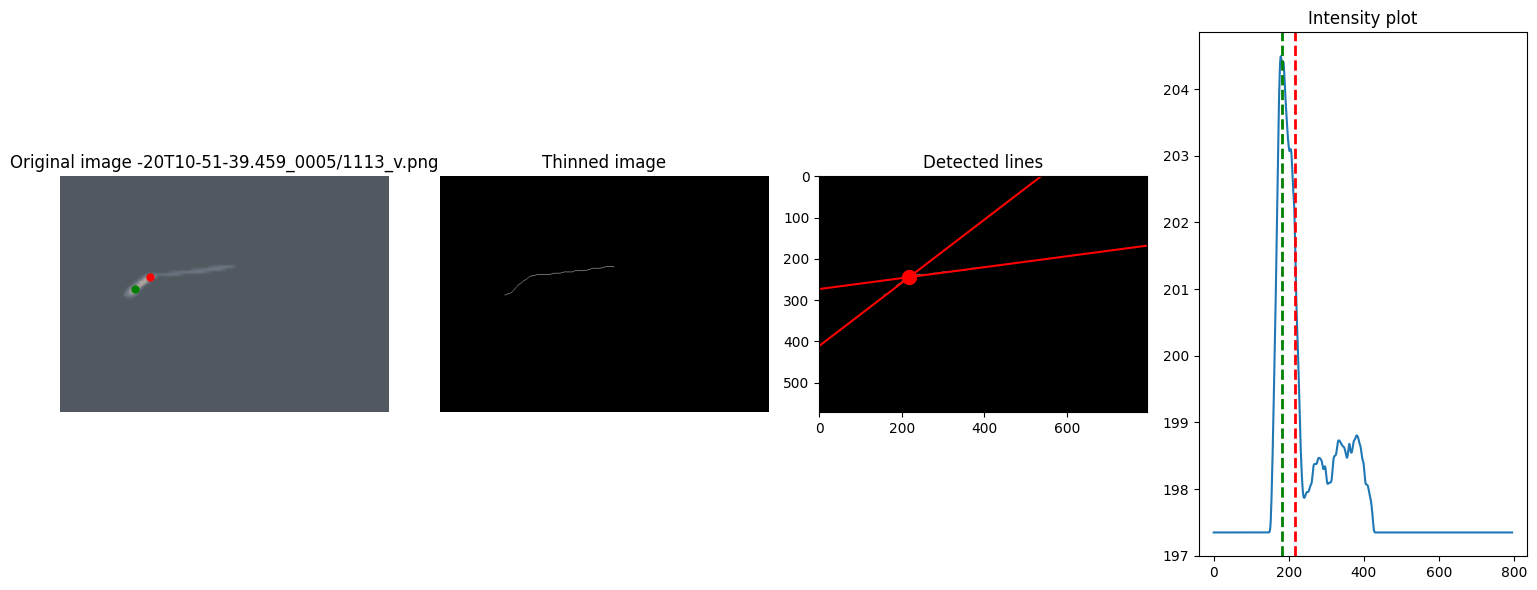

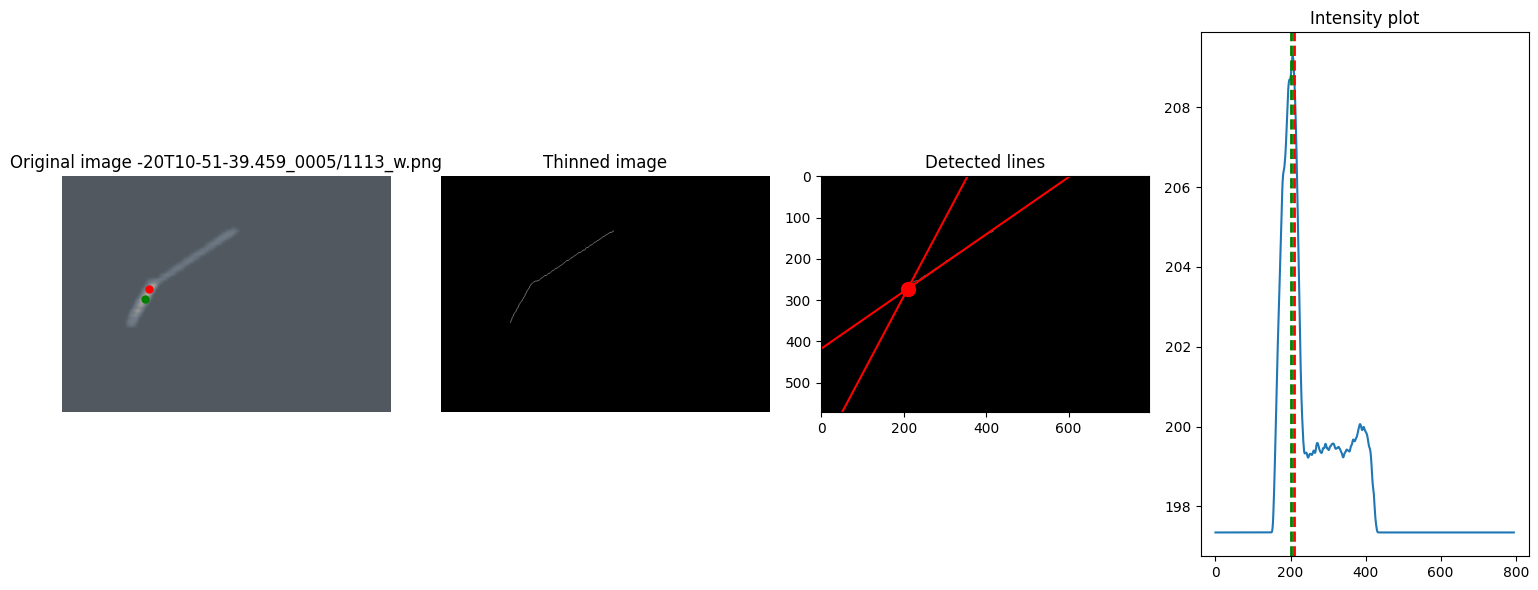

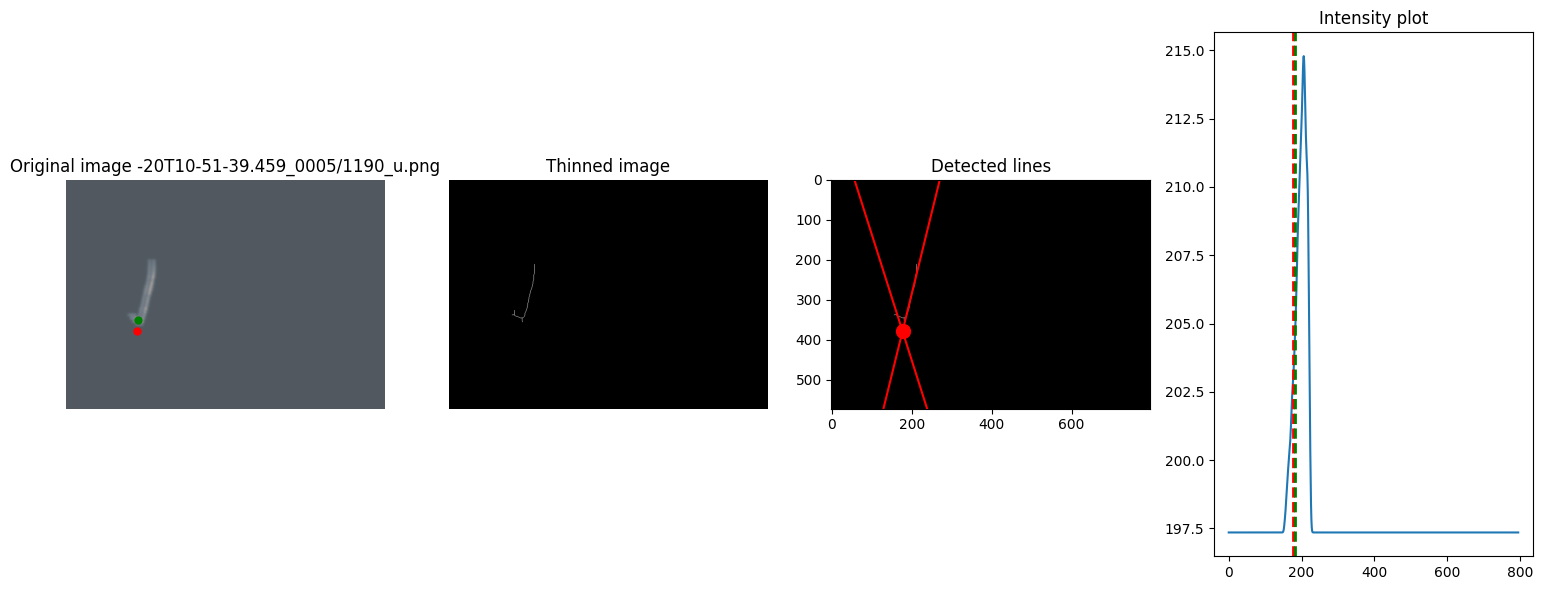

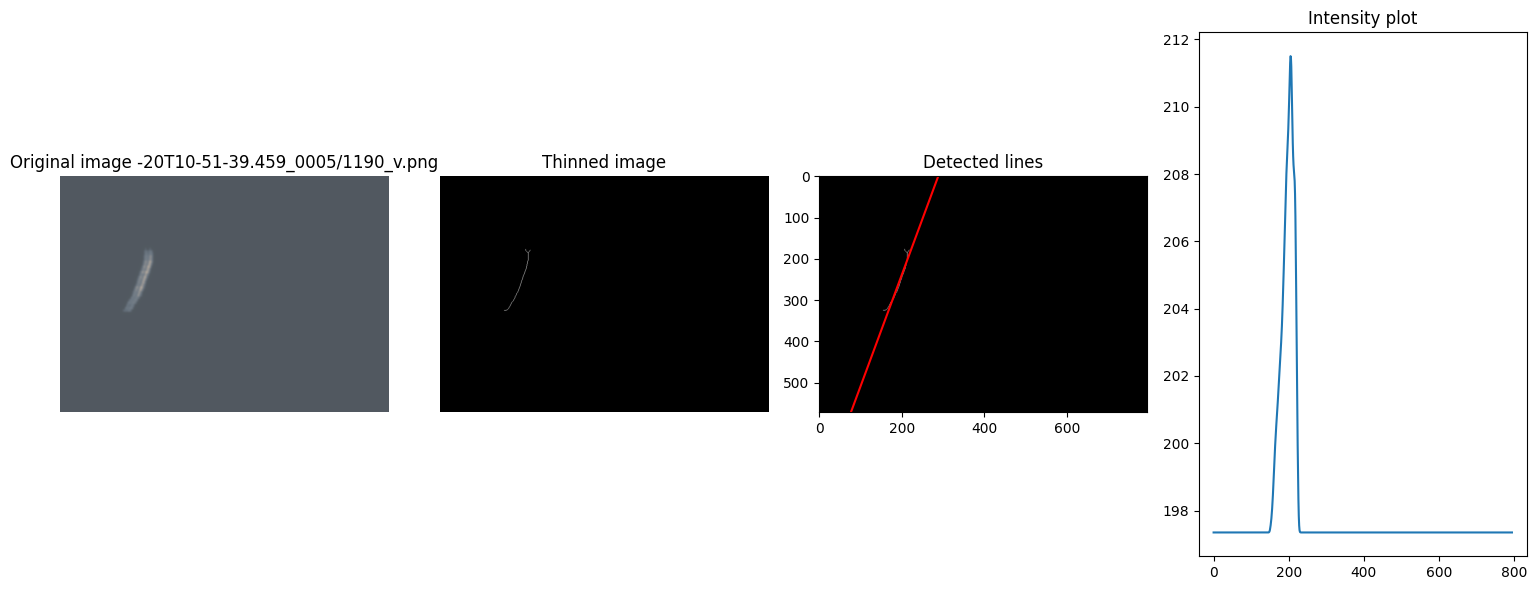

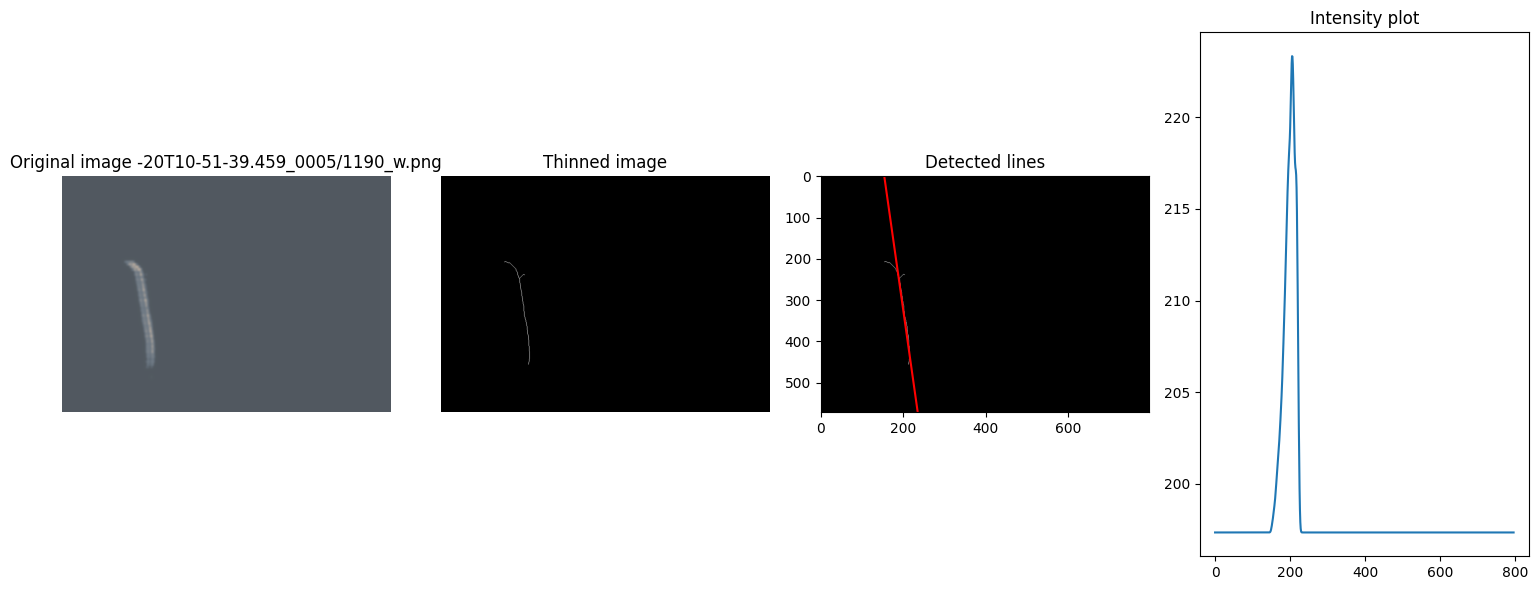

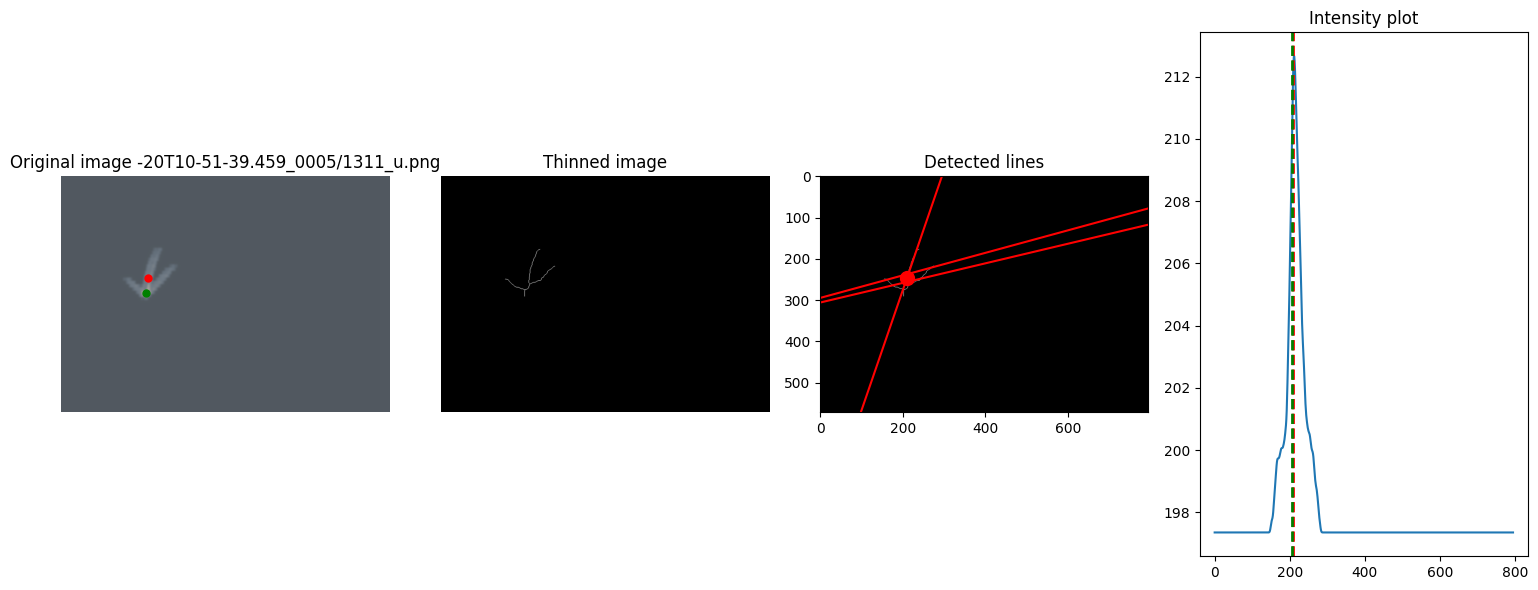

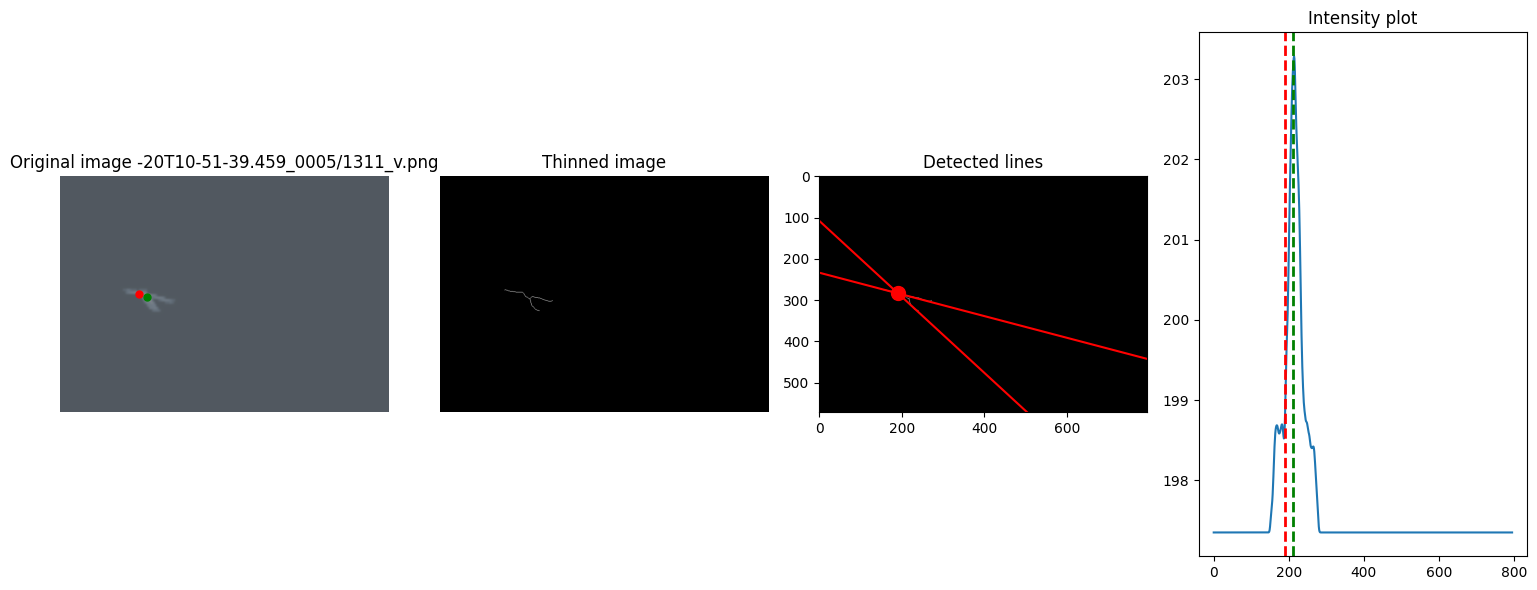

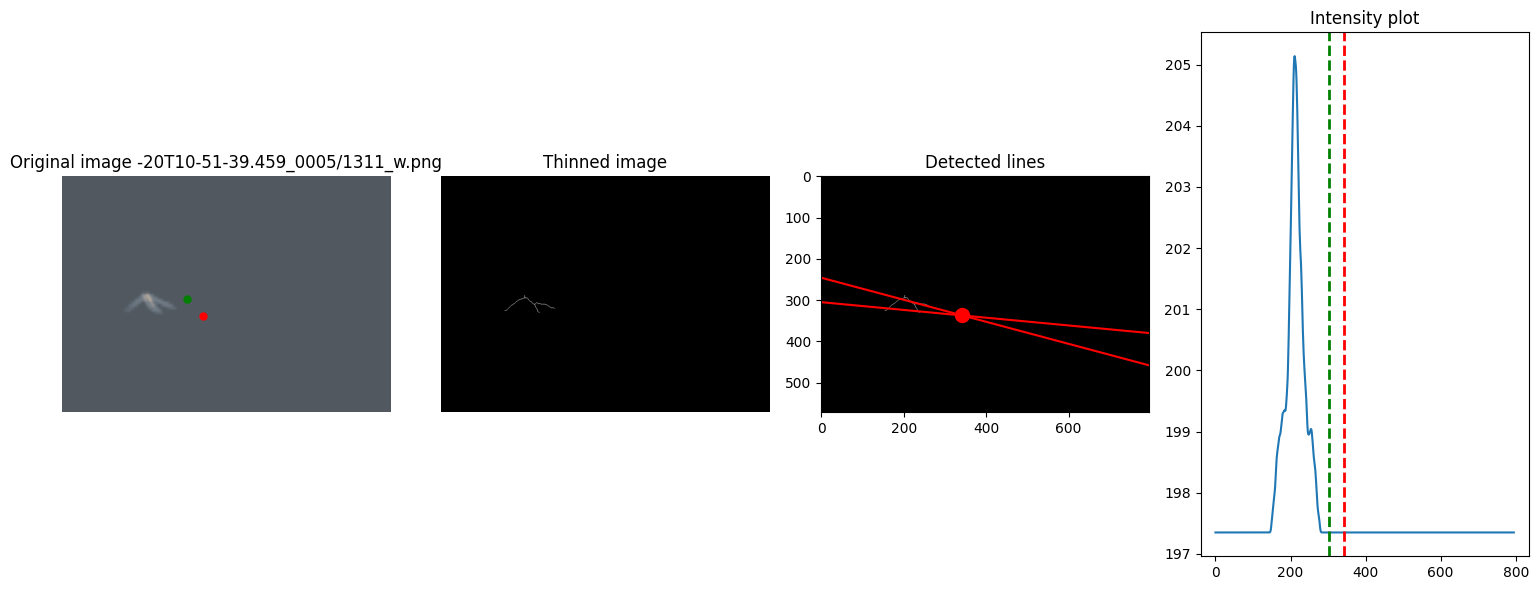

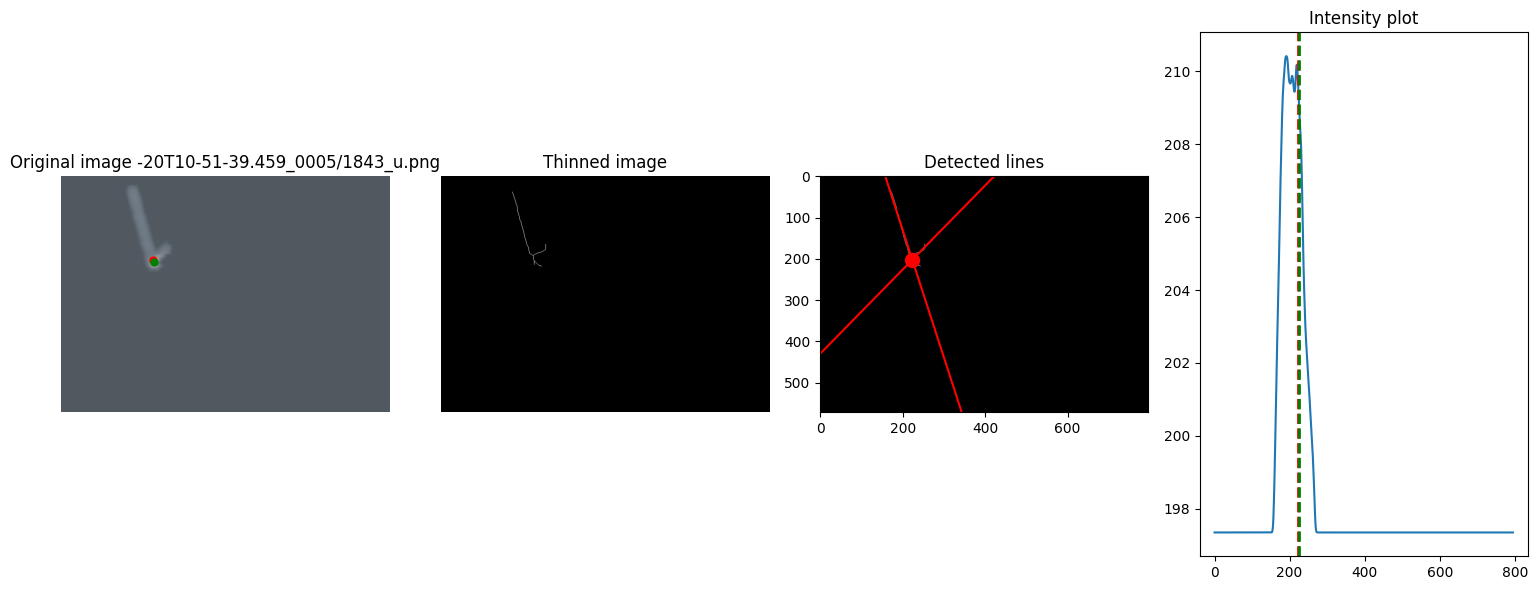

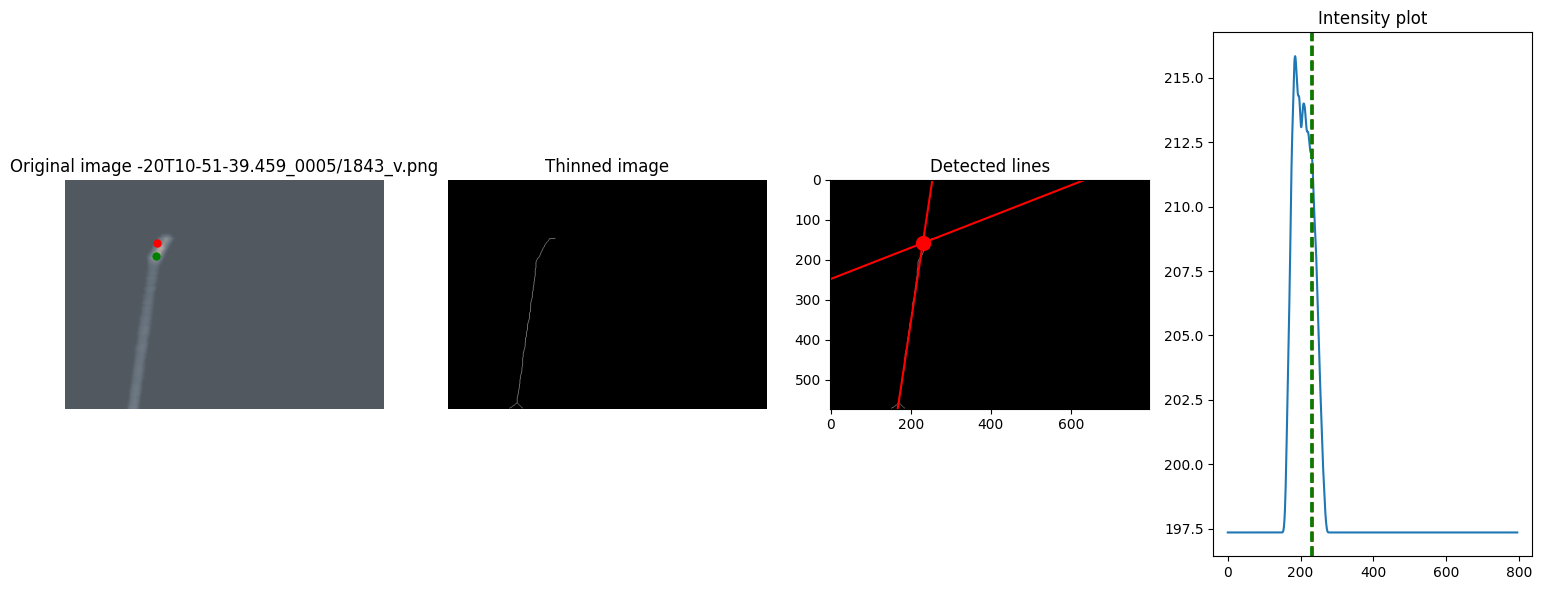

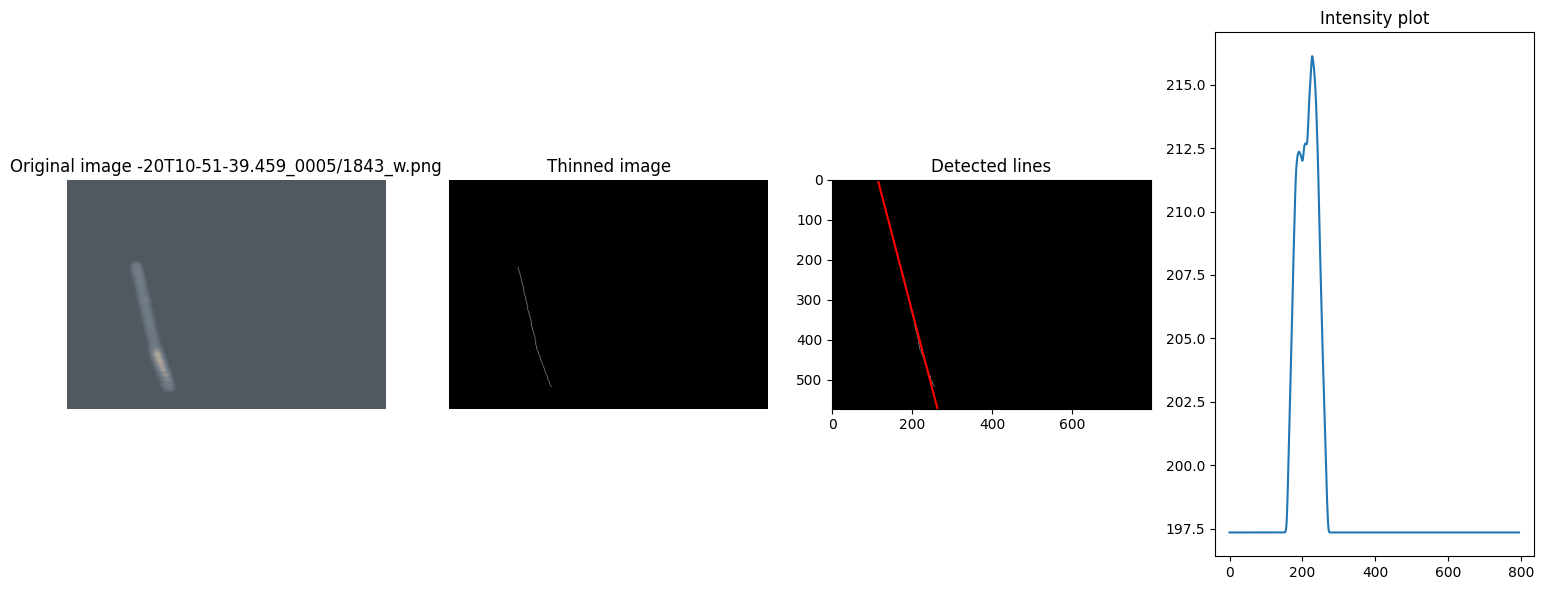

In [2]:
from skimage.morphology import skeletonize
from skimage.measure import LineModelND, ransac
from skimage.color import rgb2gray
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from src.openImage import openImage



# Remove small shapes.
def cleanNoise(image, min_size_threshold=100):

    # Apply a different label for each shape.
    labeled_image, num_labels = ndimage.label(image)

    # Count the size of each labes which is the size of each shape. Remember to address the fact that 0 is not a real label and is background.
    sizes = np.bincount(labeled_image.ravel())

    # Exclude the background label (0) from the sizes array.
    sizes[0] = 0

    # Remove small connected components
    filtered_image = np.where(sizes[labeled_image] < min_size_threshold, 0, 1)

    return filtered_image

def cutTenPixels(data):

    height, width= data.shape

    # Set the border pixels to 0
    data[:10, :] = 0  # Top border
    data[height-10:, :] = 0  # Bottom border
    data[:, :10] = 0  # Left border
    data[:, width-10:] = 0  # Right border

    return data

def perpendicular_distance(point, slope, intercept):
            x, y = point
            return np.abs(slope * x - y + intercept) / np.sqrt(slope**2 + 1)

def filterOutliers(outliers, points, slope, intercept, distance_threshold):

    # Calculate perpendicular distance for all points
    distances = np.array([perpendicular_distance(point, slope, intercept) for point in points])

    # Exclude points within the set distance from the line
    filtered_outliers = np.logical_and(outliers, distances > distance_threshold)

    return filtered_outliers

def calculateLines(min_samples, residual_threshold, distance_th, points, max_lines, seed=0):

    lines_eq = []

    for i in range(max_lines):

        if (len(points) < min_samples + 1):
            # print(f"\nStopped at iteration number {i}\n\n")
            break

        model, inliers = ransac(
            points, LineModelND, min_samples=min_samples, residual_threshold=residual_threshold, random_state=seed)

        outliers = inliers == False

        if (type(model) is type(None)):
            break

        if (model.params[1][0] == 0):
            slope = 999  # temporary fix
        else:
            slope = model.params[1][1] / \
                model.params[1][0]
        intercept = model.params[0][1] - \
            slope * model.params[0][0]

        outliers = filterOutliers(outliers, points, slope, intercept, distance_th)

        points = points[outliers]

        lines_eq.append([slope, intercept])





    return lines_eq


def movePoint(grey_image, x, y, radius=15, cluster_radius = 2):

    

    # Convert coordinates to integers
    y, x = int(y), int(x)
    
    # Get the dimensions of the image
    height, width = grey_image.shape
    
    # Define the search range, ensuring we stay within image bounds
    x_min = max(x - radius, 0)
    x_max = min(x + radius, width - 1)
    y_min = max(y - radius, 0)
    y_max = min(y + radius, height - 1)
    
    # Initialize variables to keep track of the highest average brightness and its coordinates
    max_avg_brightness = -1
    max_coords = (x, y)
    
    # Iterate over the search range
    for i in range(y_min, y_max + 1):
        for j in range(x_min, x_max + 1):
            # Define the cluster range, ensuring we stay within image bounds
            cluster_x_min = max(j - cluster_radius, 0)
            cluster_x_max = min(j + cluster_radius, width - 1)
            cluster_y_min = max(i - cluster_radius, 0)
            cluster_y_max = min(i + cluster_radius, height - 1)
            
            # Extract the cluster
            cluster = grey_image[cluster_y_min:cluster_y_max+1, cluster_x_min:cluster_x_max+1]
            
            # Calculate the average brightness of the cluster
            avg_brightness = np.mean(cluster)
            
            # Update the maximum average brightness and coordinates if necessary
            if avg_brightness > max_avg_brightness:
                max_avg_brightness = avg_brightness
                max_coords = (j, i)
    
    return max_coords

    """ # Convert coordinates to integers
    y, x = int(y), int(x)
    
    # Get the dimensions of the image
    height, width = grey_image.shape
    
    # Define the search range, ensuring we stay within image bounds
    x_min = max(x - radius, 0)
    x_max = min(x + radius, width - 1)
    y_min = max(y - radius, 0)
    y_max = min(y + radius, height - 1)
    
    # Create a grid of coordinates within the search range
    x_coords, y_coords = np.meshgrid(np.arange(x_min, x_max + 1), np.arange(y_min, y_max + 1))
    
    # Function to calculate average brightness of a cluster centered at (cx, cy)
    def average_brightness(cx, cy):
        cluster_x_min = max(cx - cluster_radius, 0)
        cluster_x_max = min(cx + cluster_radius, width - 1)
        cluster_y_min = max(cy - cluster_radius, 0)
        cluster_y_max = min(cy + cluster_radius, height - 1)
        cluster = grey_image[cluster_y_min:cluster_y_max+1, cluster_x_min:cluster_x_max+1]
        return np.mean(cluster)
    
    # Vectorize the average_brightness function to apply it to arrays
    vectorized_avg_brightness = np.vectorize(average_brightness)
    
    # Calculate the average brightness for each point in the search range
    avg_brightness_values = vectorized_avg_brightness(x_coords, y_coords)
    
    # Find the coordinates of the maximum average brightness
    max_idx = np.argmax(avg_brightness_values)
    max_y, max_x = np.unravel_index(max_idx, avg_brightness_values.shape)
    
    # Convert to coordinates relative to the original image
    new_x = x_min + max_x
    new_y = y_min + max_y
    
    return new_x, new_y """

    


def fitImage(path_and_name_input, path_and_name_output=None):


    ################### PARAMETERS TO BE CHANGED ###################
    """ min_samples = 10 #Numbers without skeletonize
    residual_threshold = 12
    white_th = 0.35#0.15
    distance_th = 20.0
    max_lines = 7
    seeds = 1#15 """

    smooth_sigma = 1.75
    min_samples = 20
    residual_threshold = 7
    white_th = 0.35#0.15
    distance_th = 15.0
    max_lines = 7
    seeds = 15
    ##############################################################

    test_image = openImage(path_and_name_input)
    test_image.readImage()

    test_image.m_data = ndimage.gaussian_filter(test_image.m_data, smooth_sigma)

    original_image = test_image.m_data


    # Black and white
    test_image.m_data = rgb2gray(test_image.m_data)

    grey_image = test_image.m_data

    # Draw the plot for the intensity
    column_sums = np.sum(grey_image, axis=0)



    # Turn completely black and white
    test_image.m_data = np.where(test_image.m_data < white_th, 0, 1)

    #########################################
    ########### FOR WHITE BORDER ############
    #test_image.m_data = cutTenPixels(test_image.m_data)
    #########################################
    #########################################

    test_image.m_data = cleanNoise(test_image.m_data, 100)
    test_image.m_data = skeletonize(test_image.m_data)

    fig, axes = plt.subplots(1, 4, figsize=(15, 6))
    ax = axes.ravel()

    ax[0].imshow(original_image)
    ax[0].set_title('Original image ' + path_and_name_input[70:])
    ax[0].set_axis_off()

    ax[1].imshow(test_image.m_data, cmap=cm.gray)
    ax[1].set_title('Thinned image')
    ax[1].set_axis_off()

    ax[2].imshow(test_image.m_data, cmap=cm.gray)
    ax[2].set_ylim((test_image.m_data.shape[0], 0))
    # ax[2].set_axis_off()
    ax[2].set_title('Detected lines')

    ax[3].plot(column_sums)
    ax[3].set_title('Intensity plot')
    

    ransac_data = test_image.m_data

    points = np.argwhere(ransac_data == 1)[:, ::-1]

    lines_eq = calculateLines(min_samples, residual_threshold, distance_th, points, max_lines, 0)


    for seed in range(1, seeds):

        old_lines_eq = lines_eq

        new_lines_eq = calculateLines(min_samples, residual_threshold, distance_th, points, max_lines, seed)

        lines_eq = []

        for i in range(max(len(old_lines_eq), len(new_lines_eq))):

            old_line = old_lines_eq[i] if i < len(old_lines_eq) else new_lines_eq[i]
            new_line = new_lines_eq[i] if i < len(new_lines_eq) else old_lines_eq[i]

            mean_slope = (old_line[0] + new_line[0]) / 2
            mean_intercept = (old_line[1] + new_line[1]) / 2

            # Check if the lines are close
            proximity_threshold = 0.2

            slope_close = abs(new_line[0] - old_line[0]) / abs(old_line[0]) <= proximity_threshold
            intercept_close = abs(new_line[1] - old_line[1]) / abs(old_line[1]) <= proximity_threshold

            # If both slope and intercept are close, calculate the mean
            if slope_close and intercept_close:
                mean_slope = (old_line[0] + new_line[0]) / 2
                mean_intercept = (old_line[1] + new_line[1]) / 2
            else:
                mean_slope = old_line[0]
                mean_intercept = old_line[1]

            lines_eq.append([mean_slope, mean_intercept])



    # Display the lines
    for i, (slope, intercept) in enumerate(lines_eq):

        #print(f"Line {i}: y = {slope} * x + {intercept}")

        x = np.arange(0, test_image.m_data.shape[1])
        y = slope * x + intercept
        ax[2].plot(x, y, label=f"Fitted line {i}", color='red')

    # Calculate the intersection
    intersections = []

    for i, (slope1, intercept1) in enumerate(lines_eq):
        for slope2, intercept2 in lines_eq[i + 1:]:
            if slope1 != slope2:  # Lines are not parallel
                x = (intercept2 - intercept1) / (slope1 - slope2)
                y = slope1 * x + intercept1
                if (x > 0 and x < 800 and y > 0 and y < 600):
                    intersections.append((x, y))

    if (len(intersections) != 0):
        average_x = sum(
            map(lambda point: point[0], intersections)) / len(intersections)
        average_y = sum(
            map(lambda point: point[1], intersections)) / len(intersections)
        

        ax[2].plot(average_x, average_y, marker='o',
                   markersize=10, color='red')
        ax[0].plot(average_x, average_y, marker='o', markersize=5, color='red')

        #new_x, new_y = movePoint(grey_image, average_x, average_y, 30, 4)
        new_x, new_y = movePoint(grey_image, average_x, average_y, 40, 6)

        ax[0].plot(new_x, new_y, marker='o', markersize=5, color='green')

        ax[3].axvline(x=average_x, color='r', linestyle='--', linewidth=2)
        ax[3].axvline(x=new_x, color='green', linestyle='--', linewidth=2)

    plt.tight_layout()
    # plt.show()
    plt.savefig(path_and_name_output)







# Make sure the dirs exist befoe calling the function. Don't have time to make sure in code.
image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages2/"
#image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages_bw/"
#image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages_bw_fpn_only/"
#image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/BAD_cleanimages_bw_fpn_and_smooth/"

image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25",
              "CoBo_2018-06-20T10-51-39.459_0002/511",
              "CoBo_2018-06-20T10-51-39.459_0002/672",
              "CoBo_2018-06-20T10-51-39.459_0002/1019",
              "CoBo_2018-06-20T10-51-39.459_0003/1319",
              "CoBo_2018-06-20T10-51-39.459_0003/1428",
              "CoBo_2018-06-20T10-51-39.459_0004/114",
              "CoBo_2018-06-20T10-51-39.459_0004/319",
              "CoBo_2018-06-20T10-51-39.459_0004/417",
              "CoBo_2018-06-20T10-51-39.459_0004/448",
              "CoBo_2018-06-20T10-51-39.459_0004/1456",
              "CoBo_2018-06-20T10-51-39.459_0004/1596",
              "CoBo_2018-06-20T10-51-39.459_0004/1725",
              "CoBo_2018-06-20T10-51-39.459_0005/477",
              "CoBo_2018-06-20T10-51-39.459_0005/677",
              "CoBo_2018-06-20T10-51-39.459_0005/1113",
              "CoBo_2018-06-20T10-51-39.459_0005/1190",
              "CoBo_2018-06-20T10-51-39.459_0005/1311",
              "CoBo_2018-06-20T10-51-39.459_0005/1843"]

image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/fittedimages2/"


for image in image_list:
    for suffix in image_suffix_list:
        fitImage((image_path + image + suffix), (output_path + image + suffix))
